In [4]:
# ============================================
# CELL 1: Configuration
# ============================================
# CONFIG — edit as needed

IN_DIR = "../Datasets/Ingestor"
COMBINED_OUT = "../Datasets/XGB_Train/pairs_combined_with_ids.csv"

# Core
GLOB_PATTERN = "*.csv"
RECURSIVE = False
ID_COL = None
NEG_PER_POS = 9

# Column split options
COLUMN_SPLIT_MODE = "half"
COLUMN_SPLIT_SHUFFLE = False
EXPLICIT_COLS_A = []
EXPLICIT_COLS_B = []

# Row cap per CSV
ROW_LIMIT = 10_000
ROW_LIMIT_MODE = "head"

# Date parsing → Unix timestamp
DATE_MIN_VALID_FRACTION = 0.50
NUMERIC_MIN_VALID_FRACTION = 0.98
UNIX_UNIT = "s"

# Logging
LOG_EVERY_FILES = 10
LOG_LEVEL = "INFO"
LOG_FILE = None

# Columns to DROP from the OUTPUT file
DROP_FROM_OUTPUT = [
    "num_nan_a", "num_nan_b", "num_nan_mismatch",
    "row_idx_A", "row_idx_B", "label_type", "source_file"
]

print("✓ Configuration loaded")

✓ Configuration loaded


In [5]:
# ============================================
# CELL 2: Imports
# ============================================
from __future__ import annotations

import glob
import logging
import os
import time
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For XGBoost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler

print("✓ Imports loaded")

✓ Imports loaded


In [6]:
# ============================================
# CELL 3: Logging Setup
# ============================================
def setup_logging(level: str = "INFO", logfile: Optional[str] = None):
    lvl = getattr(logging, level.upper(), logging.INFO)
    fmt = "%(asctime)s | %(levelname)-7s | %(message)s"
    datefmt = "%Y-%m-%d %H:%M:%S"
    
    handlers = [logging.StreamHandler()]
    if logfile:
        logdir = os.path.dirname(os.path.abspath(logfile))
        if logdir:
            os.makedirs(logdir, exist_ok=True)
        handlers.append(logging.FileHandler(logfile, mode="w", encoding="utf-8"))
    
    try:
        logging.basicConfig(level=lvl, format=fmt, datefmt=datefmt, handlers=handlers, force=True)
    except TypeError:
        root = logging.getLogger()
        for h in list(root.handlers):
            root.removeHandler(h)
        logging.basicConfig(level=lvl, format=fmt, datefmt=datefmt, handlers=handlers)

setup_logging(LOG_LEVEL, LOG_FILE)
print("✓ Logging configured")

✓ Logging configured


In [7]:
# ============================================
# CELL 4: Data Processing Helpers
# ============================================
def _clean_numeric_like_text(s: pd.Series) -> pd.Series:
    """Remove common decorators like commas/spaces before numeric coercion."""
    return (s.astype(str)
              .str.replace(",", "", regex=False)
              .str.replace(" ", "", regex=False)
              .str.replace("\u00A0", "", regex=False))


def detect_numeric_columns(df: pd.DataFrame, *, id_col: Optional[str], min_valid_fraction: float) -> List[str]:
    """Columns that are numeric or safely numeric after cleaning."""
    cols = [c for c in df.columns if (id_col is None or c != id_col)]
    numeric_cols = []
    for c in cols:
        s_num = pd.to_numeric(_clean_numeric_like_text(df[c]), errors="coerce")
        if s_num.notna().mean() >= min_valid_fraction:
            numeric_cols.append(c)
    return numeric_cols


def datetime_series_to_unix(dt: pd.Series, unit: str) -> pd.Series:
    """Convert timezone-aware datetime64[ns] Series to Unix timestamps."""
    arr_dt = dt.to_numpy(dtype="datetime64[ns]")
    mask_nat = np.isnat(arr_dt)
    arr_ns = arr_dt.astype("datetime64[ns]").astype("int64").astype("float64")
    arr_ns[mask_nat] = np.nan
    if unit == "ms":
        return pd.Series(arr_ns / 1e6, index=dt.index, dtype="float64")
    else:
        return pd.Series(arr_ns / 1e9, index=dt.index, dtype="float64")


def convert_only_non_numeric_dates_to_unix(
    df: pd.DataFrame,
    *,
    id_col: Optional[str],
    numeric_min_valid_fraction: float,
    date_min_valid_fraction: float,
    unit: str,
) -> Tuple[pd.DataFrame, List[str]]:
    """Only non-numeric columns are tested as dates and converted to Unix."""
    df = df.copy()
    candidate_cols = [c for c in df.columns if (id_col is None or c != id_col)]
    numeric_cols = set(detect_numeric_columns(df, id_col=id_col, min_valid_fraction=numeric_min_valid_fraction))
    
    converted = []
    for c in candidate_cols:
        if c in numeric_cols:
            continue
        dt = pd.to_datetime(df[c], errors="coerce", utc=True)
        if dt.notna().mean() >= date_min_valid_fraction:
            df[c] = datetime_series_to_unix(dt, unit=unit)
            converted.append(c)
    
    return df, converted


def as_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Coerce columns to numeric."""
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(_clean_numeric_like_text(out[c]), errors="coerce")
    return out


def zscore(arr: np.ndarray) -> np.ndarray:
    m = np.nanmean(arr, axis=0)
    s = np.nanstd(arr, axis=0)
    s[s == 0] = np.nan
    Z = (arr - m) / s
    return np.where(np.isnan(Z), 0.0, Z)


def percentile_rank_matrix(arr: np.ndarray) -> np.ndarray:
    n, d = arr.shape
    out = np.full((n, d), 0.5, dtype=float)
    for j in range(d):
        col = arr[:, j]
        mask = ~np.isnan(col)
        if mask.sum() <= 1:
            continue
        order = np.argsort(col[mask], kind="mergesort")
        ranks = np.empty_like(order, dtype=float)
        ranks[order] = np.arange(order.size)
        pct = ranks / (mask.sum() - 1)
        out[mask, j] = pct
    return out


def safe_ratio(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    den = np.where(np.abs(b) < 1e-12, np.nan, b)
    return a / den

print("✓ Data processing helpers loaded")

✓ Data processing helpers loaded


In [8]:
# ============================================
# CELL 5: ENHANCED Feature Engineering Function
# ============================================
def enhanced_pair_features_numeric(a_raw, b_raw, a_z, b_z, a_pct, b_pct) -> dict:
    """
    🆕 ENHANCED: Added 10+ new discriminative features
    
    New features:
    - absdiff_max, absdiff_min, absdiff_std
    - reldiff_median
    - zdiff_max
    - pcdiff_sq_mean (emphasizes large differences)
    - correlation (between A and B vectors)
    - ratio_mean, ratio_median, ratio_std
    - sign_agreement
    - n_both_zero, n_close, n_very_close
    """
    
    def nanmean(x): 
        m = np.nanmean(x)
        return float(m) if np.isfinite(m) else np.nan
    
    def nansum(x): 
        return float(np.nansum(x))
    
    # Core differences
    absdiff = np.abs(a_raw - b_raw)
    reldiff = np.abs(safe_ratio(a_raw - b_raw, (np.abs(a_raw) + np.abs(b_raw)) / 2 + 1e-12))
    zdiff = np.abs(a_z - b_z)
    pcdiff = np.abs(a_pct - b_pct)
    
    # Base features (original)
    features = {
        # Absolute differences
        "absdiff_mean": nanmean(absdiff),
        "absdiff_median": float(np.nanmedian(absdiff)),
        "absdiff_max": float(np.nanmax(absdiff)),           # 🆕 NEW
        "absdiff_min": float(np.nanmin(absdiff)),           # 🆕 NEW
        "absdiff_std": float(np.nanstd(absdiff)),           # 🆕 NEW
        
        # Relative differences
        "reldiff_mean": nanmean(reldiff),
        "reldiff_median": float(np.nanmedian(reldiff)),     # 🆕 NEW
        
        # Z-score differences
        "zdiff_mean": nanmean(zdiff),
        "zdiff_max": float(np.nanmax(zdiff)),               # 🆕 NEW
        
        # Percentile differences
        "pcdiff_mean": nanmean(pcdiff),
        "pcdiff_sq_mean": nanmean(pcdiff ** 2),             # 🆕 NEW - emphasize large diffs
        
        # L-norms
        "L1_raw": nansum(absdiff),
        "L2_raw": float(np.sqrt(np.nansum(absdiff**2))),
        "L1_z": nansum(zdiff),
        "L2_z": float(np.sqrt(np.nansum(zdiff**2))),
        "L1_pct": nansum(pcdiff),
        "L2_pct": float(np.sqrt(np.nansum(pcdiff**2))),
        
        # 🆕 NEW: Correlation-like measure
        "correlation": 0.0,
        
        # 🆕 NEW: Ratio features
        "ratio_mean": 0.0,
        "ratio_median": 0.0,
        "ratio_std": 0.0,
        
        # 🆕 NEW: Sign agreement
        "sign_agreement": 0.0,
        
        # 🆕 NEW: Count-based features
        "n_features": len(a_raw),
        "n_both_zero": 0,
        "n_close": 0,        # Within 0.1 absolute difference
        "n_very_close": 0,   # Within 0.01
        
        # Diagnostics (will be dropped from output)
        "num_nan_a": float(np.isnan(a_raw).sum()),
        "num_nan_b": float(np.isnan(b_raw).sum()),
        "num_nan_mismatch": float((np.isnan(a_raw) ^ np.isnan(b_raw)).sum()),
    }
    
    # Compute correlation
    valid_mask = ~(np.isnan(a_raw) | np.isnan(b_raw))
    if valid_mask.sum() > 1:
        a_valid = a_raw[valid_mask]
        b_valid = b_raw[valid_mask]
        if len(a_valid) > 1 and np.std(a_valid) > 0 and np.std(b_valid) > 0:
            try:
                features['correlation'] = float(np.corrcoef(a_valid, b_valid)[0, 1])
            except:
                features['correlation'] = 0.0
    
    # Compute ratios
    ratios = safe_ratio(a_raw, b_raw)
    if not np.all(np.isnan(ratios)):
        features['ratio_mean'] = nanmean(ratios)
        features['ratio_median'] = float(np.nanmedian(ratios))
        features['ratio_std'] = float(np.nanstd(ratios))
    
    # Sign agreement
    if valid_mask.sum() > 0:
        sign_agreement = ((a_raw[valid_mask] > 0) == (b_raw[valid_mask] > 0)).astype(float)
        features['sign_agreement'] = float(np.mean(sign_agreement))
    
    # Count features
    features['n_both_zero'] = int(((a_raw == 0) & (b_raw == 0)).sum())
    features['n_close'] = int((absdiff < 0.1).sum())
    features['n_very_close'] = int((absdiff < 0.01).sum())
    
    return features

print("✓ Enhanced feature engineering function loaded")
print("  → Added 10+ new features for better discrimination")

✓ Enhanced feature engineering function loaded
  → Added 10+ new features for better discrimination


In [9]:
# ============================================
# CELL 6: Column Split Function
# ============================================
def split_numeric_columns(
    df: pd.DataFrame,
    *,
    id_col: Optional[str],
    mode: str = "half",
    shuffle: bool = False,
    seed: int = 42,
    explicit_A: Optional[List[str]] = None,
    explicit_B: Optional[List[str]] = None,
    min_valid_fraction: float = 0.01,
) -> Tuple[List[str], List[str]]:
    """Return (cols_A, cols_B) disjoint numeric feature lists."""
    all_cols = df.columns.tolist()
    feature_cols = [c for c in all_cols if (id_col is None or c != id_col)]
    
    valid_frac = {}
    for c in feature_cols:
        s = pd.to_numeric(_clean_numeric_like_text(df[c]), errors="coerce")
        valid_frac[c] = s.notna().mean()
    
    numeric_ok = [c for c in feature_cols if valid_frac[c] >= min_valid_fraction]
    
    if explicit_A and explicit_B:
        missing = [c for c in (explicit_A + explicit_B) if c not in numeric_ok]
        if missing:
            raise ValueError(f"Explicit columns not usable: {missing}")
        overlap = set(explicit_A).intersection(explicit_B)
        if overlap:
            raise ValueError(f"Explicit A/B overlap: {overlap}")
        return list(explicit_A), list(explicit_B)
    
    cols = numeric_ok.copy()
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(cols)
    
    dropped = [c for c in feature_cols if c not in numeric_ok]
    if dropped:
        logging.warning(f"Dropping {len(dropped)} non-usable column(s): {dropped[:10]}{'...' if len(dropped)>10 else ''}")
    
    mid = len(cols) // 2
    cols_A, cols_B = cols[:mid], cols[mid:]
    if len(cols_A) == 0 or len(cols_B) == 0:
        raise ValueError("Column split resulted in an empty side")
    return cols_A, cols_B

print("✓ Column split function loaded")

✓ Column split function loaded


In [10]:
# ============================================
# CELL 7: Pair Building Function (Using Enhanced Features)
# ============================================
def build_pairs_from_single_df_column_split(
    df: pd.DataFrame,
    *,
    id_col: Optional[str],
    negatives_per_positive: int,
    seed: int,
    source_file: str,
    column_split_mode: str = "half",
    column_split_shuffle: bool = False,
    explicit_cols_A: Optional[List[str]] = None,
    explicit_cols_B: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """Build pairs using ENHANCED feature engineering."""
    
    rng = np.random.default_rng(seed)
    
    # Ensure ID column
    if id_col is None or id_col not in df.columns:
        df = df.copy()
        df["_row_id"] = np.arange(len(df)).astype(str)
        stem = os.path.splitext(os.path.basename(source_file))[0]
        df["_row_id"] = stem + "::" + df["_row_id"]
        id_col_eff = "_row_id"
        logging.debug(f"[{source_file}] Synthetic ID created")
    else:
        id_col_eff = id_col
    
    # Convert dates to Unix
    df, converted = convert_only_non_numeric_dates_to_unix(
        df, id_col=id_col_eff,
        numeric_min_valid_fraction=NUMERIC_MIN_VALID_FRACTION,
        date_min_valid_fraction=DATE_MIN_VALID_FRACTION,
        unit=UNIX_UNIT,
    )
    if converted:
        logging.info(f"Converted {len(converted)} date columns: {converted}")
    
    # Split columns
    cols_A, cols_B = split_numeric_columns(
        df, id_col=id_col_eff,
        mode=column_split_mode, shuffle=column_split_shuffle, seed=seed,
        explicit_A=explicit_cols_A, explicit_B=explicit_cols_B,
    )
    logging.info(f"[{os.path.basename(source_file)}] Split: A={len(cols_A)}, B={len(cols_B)}")
    
    # Coerce to numeric
    df = as_numeric(df, cols_A + cols_B)
    
    A = df[[id_col_eff] + cols_A].copy()
    B = df[[id_col_eff] + cols_B].copy()
    XA = A[cols_A].to_numpy(dtype=float)
    XB = B[cols_B].to_numpy(dtype=float)
    
    # Standardize
    ZA = zscore(XA.copy())
    ZB = zscore(XB.copy())
    PA = percentile_rank_matrix(XA.copy())
    PB = percentile_rank_matrix(XB.copy())
    
    n = len(df)
    if n < 2:
        raise ValueError("Need at least 2 rows")
    
    # Build pairs
    pos_pairs, neg_pairs = [], []
    all_indices = np.arange(n)
    for i in range(n):
        pos_pairs.append((i, i))
        size = min(negatives_per_positive, n - 1)
        if size > 0:
            candidates = np.delete(all_indices, i)
            choices = rng.choice(candidates, size=size, replace=False)
            for j in choices:
                neg_pairs.append((i, j))
    
    # 🆕 Compute features using ENHANCED function
    X_rows, y_rows, idx_rows = [], [], []
    for (i, j) in pos_pairs:
        feats = enhanced_pair_features_numeric(XA[i], XB[j], ZA[i], ZB[j], PA[i], PB[j])
        X_rows.append(feats)
        y_rows.append(1)
        idx_rows.append({
            "idA": A[id_col_eff].iloc[i],
            "idB": B[id_col_eff].iloc[j],
            "row_idx_A": i,
            "row_idx_B": j,
            "label_type": "pos",
            "source_file": os.path.basename(source_file)
        })
    
    for (i, j) in neg_pairs:
        feats = enhanced_pair_features_numeric(XA[i], XB[j], ZA[i], ZB[j], PA[i], PB[j])
        X_rows.append(feats)
        y_rows.append(0)
        idx_rows.append({
            "idA": A[id_col_eff].iloc[i],
            "idB": B[id_col_eff].iloc[j],
            "row_idx_A": i,
            "row_idx_B": j,
            "label_type": "neg",
            "source_file": os.path.basename(source_file)
        })
    
    return pd.DataFrame(X_rows), pd.Series(y_rows, name="label"), pd.DataFrame(idx_rows)

print("✓ Pair building function loaded (using enhanced features)")

✓ Pair building function loaded (using enhanced features)


In [11]:
# ============================================
# CELL 8: Helper Functions
# ============================================
def _apply_row_cap(df: pd.DataFrame, cap: int, mode: str, seed: int) -> pd.DataFrame:
    if cap is None or len(df) <= cap:
        return df
    if mode == "sample":
        return df.sample(n=cap, random_state=seed)
    return df.head(cap)


def save_combined_with_ids_and_drop(
    X: pd.DataFrame, y: pd.Series, idx: pd.DataFrame, 
    out_path: str, drop_cols: List[str]
):
    """Concatenate and save."""
    df_combined = pd.concat(
        [idx.reset_index(drop=True), X.reset_index(drop=True), y.reset_index(drop=True)], 
        axis=1
    )
    
    drop_present = [c for c in drop_cols if c in df_combined.columns]
    if drop_present:
        df_combined = df_combined.drop(columns=drop_present)
        logging.info(f"Dropped from output: {drop_present}")
    
    os.makedirs(os.path.dirname(os.path.abspath(out_path)) or ".", exist_ok=True)
    ext = os.path.splitext(out_path)[1].lower()
    if ext == ".parquet":
        df_combined.to_parquet(out_path, index=False)
    else:
        df_combined.to_csv(out_path, index=False)
    logging.info(f"Saved: {out_path} | rows={len(df_combined):,}, cols={df_combined.shape[1]:,}")

print("✓ Helper functions loaded")

✓ Helper functions loaded


In [12]:
# ============================================
# CELL 9: Main Pipeline Function
# ============================================
def build_pairs_from_dir_column_split(
    in_dir: str,
    *,
    glob_pattern: str = "*.csv",
    recursive: bool = False,
    id_col: Optional[str] = None,
    negatives_per_positive: int = 9,
    seed: int = 42,
    combined_out: str = "../Datasets/XGB_Train/pairs_combined_with_ids.csv",
    log_every_files: int = 10,
    row_limit: Optional[int] = None,
    row_limit_mode: str = "head",
    column_split_mode: str = "half",
    column_split_shuffle: bool = False,
    explicit_cols_A: Optional[List[str]] = None,
    explicit_cols_B: Optional[List[str]] = None,
):
    """Multi-CSV orchestrator with enhanced features."""
    t0 = time.perf_counter()
    
    search = os.path.join(in_dir, "**", glob_pattern) if recursive else os.path.join(in_dir, glob_pattern)
    files = sorted(glob.glob(search, recursive=recursive))
    if not files:
        raise FileNotFoundError(f"No files matched: {search}")
    logging.info(f"Found {len(files):,} CSV files")
    
    all_X, all_y, all_idx = [], [], []
    total_pos, total_neg = 0, 0
    
    for k, f in enumerate(files, 1):
        df = pd.read_csv(f)
        
        original_rows = len(df)
        df = _apply_row_cap(df, row_limit, row_limit_mode, seed)
        if len(df) < original_rows:
            logging.info(f"[{k}/{len(files)}] {os.path.basename(f)} — capped {original_rows:,} -> {len(df):,}")
        
        if len(df) < 2:
            logging.warning(f"[{k}/{len(files)}] {os.path.basename(f)} has <2 rows; skipping")
            continue
        
        logging.info(f"[{k}/{len(files)}] {os.path.basename(f)} — rows={len(df):,}, cols={len(df.columns):,}")
        
        X, y, idx = build_pairs_from_single_df_column_split(
            df=df, id_col=id_col, negatives_per_positive=negatives_per_positive,
            seed=seed, source_file=f, column_split_mode=column_split_mode,
            column_split_shuffle=column_split_shuffle,
            explicit_cols_A=explicit_cols_A, explicit_cols_B=explicit_cols_B,
        )
        
        all_X.append(X)
        all_y.append(y)
        all_idx.append(idx)
        pos = int(y.sum())
        neg = len(y) - pos
        total_pos += pos
        total_neg += neg
        
        if k % log_every_files == 0:
            logging.info(f"  Progress: {k:,}/{len(files):,} | pairs={total_pos+total_neg:,} (pos={total_pos:,}, neg={total_neg:,})")
    
    if not all_y:
        raise RuntimeError("No valid CSVs")
    
    X = pd.concat(all_X, axis=0, ignore_index=True)
    y = pd.concat(all_y, axis=0, ignore_index=True)
    idx = pd.concat(all_idx, axis=0, ignore_index=True)
    
    logging.info(f"FINAL — pairs={len(y):,} (pos={int(y.sum()):,}, neg={len(y)-int(y.sum()):,}), features={X.shape[1]:,}")
    
    save_combined_with_ids_and_drop(X, y, idx, combined_out, drop_cols=DROP_FROM_OUTPUT)
    
    logging.info(f"Elapsed: {time.perf_counter() - t0:.2f}s")
    return X, y, idx

print("✓ Main pipeline function loaded")

✓ Main pipeline function loaded


In [13]:
# ============================================
# CELL 10: RUN DATA GENERATION
# ============================================
print("\n" + "="*80)
print("STARTING DATA GENERATION WITH ENHANCED FEATURES")
print("="*80 + "\n")

X_all, y_all, idx_all = build_pairs_from_dir_column_split(
    in_dir=IN_DIR,
    glob_pattern=GLOB_PATTERN,
    recursive=RECURSIVE,
    id_col=ID_COL,
    negatives_per_positive=NEG_PER_POS,
    seed=42,
    combined_out=COMBINED_OUT,
    log_every_files=LOG_EVERY_FILES,
    row_limit=ROW_LIMIT,
    row_limit_mode=ROW_LIMIT_MODE,
    column_split_mode=COLUMN_SPLIT_MODE,
    column_split_shuffle=COLUMN_SPLIT_SHUFFLE,
    explicit_cols_A=EXPLICIT_COLS_A,
    explicit_cols_B=EXPLICIT_COLS_B,
)

print("\n" + "="*80)
print("✓ DATA GENERATION COMPLETE")
print("="*80)
print(f"Saved: {COMBINED_OUT}")
print(f"Shapes — X: {X_all.shape} | y: {y_all.shape} | idx: {idx_all.shape}")
print(f"\n🆕 Features now include {X_all.shape[1]} columns (up from ~13)")
print(f"   New discriminative features: correlation, ratios, counts, etc.")


2025-11-07 21:42:54 | INFO    | Found 25 CSV files



STARTING DATA GENERATION WITH ENHANCED FEATURES



2025-11-07 21:42:55 | INFO    | [1/25] AAPL.csv — capped 987,754 -> 10,000
2025-11-07 21:42:55 | INFO    | [1/25] AAPL.csv — rows=10,000, cols=8
2025-11-07 21:42:55 | INFO    | Converted 1 date columns: ['ts']
2025-11-07 21:42:55 | INFO    | [AAPL.csv] Split: A=4, B=4
2025-11-07 21:43:19 | INFO    | [2/25] AMZN.csv — capped 824,787 -> 10,000
2025-11-07 21:43:19 | INFO    | [2/25] AMZN.csv — rows=10,000, cols=8
2025-11-07 21:43:19 | INFO    | Converted 1 date columns: ['ts']
2025-11-07 21:43:19 | INFO    | [AMZN.csv] Split: A=4, B=4
2025-11-07 21:43:43 | INFO    | [3/25] BA.csv — capped 664,841 -> 10,000
2025-11-07 21:43:43 | INFO    | [3/25] BA.csv — rows=10,000, cols=8
2025-11-07 21:43:43 | INFO    | Converted 1 date columns: ['ts']
2025-11-07 21:43:43 | INFO    | [BA.csv] Split: A=4, B=4
2025-11-07 21:44:07 | INFO    | [4/25] BAC.csv — capped 711,603 -> 10,000
2025-11-07 21:44:07 | INFO    | [4/25] BAC.csv — rows=10,000, cols=8
2025-11-07 21:44:07 | INFO    | Converted 1 date columns


✓ DATA GENERATION COMPLETE
Saved: ../Datasets/XGB_Train/pairs_combined_with_ids.csv
Shapes — X: (2500000, 29) | y: (2500000,) | idx: (2500000, 6)

🆕 Features now include 29 columns (up from ~13)
   New discriminative features: correlation, ratios, counts, etc.


In [14]:
# ============================================
# CELL 11: Train/Val/Test Split
# ============================================
COMBINED_PATH = COMBINED_OUT
OUT_DIR = os.path.dirname(COMBINED_PATH)

TRAIN_FRACTION = 0.75
VAL_FRACTION = 0.10
TEST_FRACTION = 0.15
SEED = 42

print("\n" + "="*80)
print("CREATING TRAIN/VAL/TEST SPLITS")
print("="*80)

os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(COMBINED_PATH)
assert "label" in df.columns
y = df["label"]

# First split
test_val_size = VAL_FRACTION + TEST_FRACTION
train_df, temp_df = train_test_split(
    df, test_size=test_val_size, random_state=SEED, stratify=y
)

# Second split
rel_val = VAL_FRACTION / (VAL_FRACTION + TEST_FRACTION)
temp_y = temp_df["label"]
val_df, test_df = train_test_split(
    temp_df, test_size=(1 - rel_val), random_state=SEED, stratify=temp_y
)

def summarize(split_name, d):
    counts = d["label"].value_counts(dropna=False).sort_index()
    pct = (counts / len(d)).round(4)
    print(f"{split_name:>5} | rows={len(d):,} | pos={counts.get(1, 0):,} neg={counts.get(0, 0):,} | ratio={pct.to_dict()}")

summarize("train", train_df)
summarize(" val ", val_df)
summarize("test ", test_df)

train_path = os.path.join(OUT_DIR, "train.csv")
val_path = os.path.join(OUT_DIR, "val.csv")
test_path = os.path.join(OUT_DIR, "test.csv")

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print("\nSaved:")
print(f" - {train_path}")
print(f" - {val_path}")
print(f" - {test_path}")


CREATING TRAIN/VAL/TEST SPLITS
train | rows=1,875,000 | pos=187,500 neg=1,687,500 | ratio={0: 0.9, 1: 0.1}
 val  | rows=250,000 | pos=25,000 neg=225,000 | ratio={0: 0.9, 1: 0.1}
test  | rows=375,000 | pos=37,500 neg=337,500 | ratio={0: 0.9, 1: 0.1}

Saved:
 - ../Datasets/XGB_Train/train.csv
 - ../Datasets/XGB_Train/val.csv
 - ../Datasets/XGB_Train/test.csv


In [15]:
# ============================================
# CELL 12: XGBoost Helper Functions
# ============================================
def gpu_params_for_xgb():
    """Return GPU params if available."""
    ver = tuple(int(x) for x in xgb.__version__.split(".")[:2])
    if ver >= (2, 0):
        return ({"device": "cuda", "tree_method": "hist"}, "XGB>=2: device=cuda")
    else:
        return ({"tree_method": "gpu_hist", "predictor": "gpu_predictor"}, "XGB<2: gpu_hist")


def try_gpu_or_fallback(base_params):
    """Try GPU, fall back to CPU if not available."""
    gpu_update, note = gpu_params_for_xgb()
    params = base_params.copy()
    params.update(gpu_update)
    try:
        dm = xgb.DMatrix(np.array([[0.0],[1.0]], dtype=np.float32), label=np.array([0,1], dtype=np.int32))
        xgb.train(params, dm, num_boost_round=1)
        print(f"[INFO] Using GPU -> {note}")
        return params
    except Exception as e:
        print(f"[WARN] GPU not available ({e}). Falling back to CPU")
        params = base_params.copy()
        params.update({"tree_method": "hist"})
        return params

print("✓ XGBoost GPU helpers loaded")

✓ XGBoost GPU helpers loaded


In [16]:
# ============================================
# CELL 13: 🆕 OPTIMIZED HYPERPARAMETERS
# ============================================
def get_optimized_params(objective='f2_focused', scale_pos_weight=9.0):
    """
    🆕 Get hyperparameters optimized for specific objectives.
    
    Args:
        objective: 'balanced', 'high_precision', 'high_recall', 'f2_focused'
        scale_pos_weight: Base class weight ratio
    """
    
    base = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "random_state": 42,
    }
    
    configs = {
        'balanced': {
            "learning_rate": 0.05,
            "max_depth": 6,
            "min_child_weight": 5,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0.5,
            "reg_alpha": 0.1,
            "reg_lambda": 2.0,
            "scale_pos_weight": scale_pos_weight,
        },
        
        'high_precision': {  # 🎯 Fewer False Positives
            "learning_rate": 0.03,
            "max_depth": 4,              # Shallower
            "min_child_weight": 15,      # More evidence needed
            "subsample": 0.7,
            "colsample_bytree": 0.7,
            "gamma": 3.0,                # Stricter splits
            "reg_alpha": 1.0,
            "reg_lambda": 10.0,          # Strong regularization
            "scale_pos_weight": scale_pos_weight * 1.5,
        },
        
        'high_recall': {  # 🎯 More True Positives
            "learning_rate": 0.02,
            "max_depth": 8,              # Deeper
            "min_child_weight": 1,       # Allow finer splits
            "subsample": 0.95,
            "colsample_bytree": 0.95,
            "gamma": 0.0,
            "reg_alpha": 0.0,
            "reg_lambda": 0.5,
            "scale_pos_weight": scale_pos_weight * 0.7,
        },
        
        'f2_focused': {  # 🎯 Slight recall preference (RECOMMENDED)
            "learning_rate": 0.04,
            "max_depth": 6,
            "min_child_weight": 4,
            "subsample": 0.85,
            "colsample_bytree": 0.85,
            "gamma": 0.3,
            "reg_alpha": 0.05,
            "reg_lambda": 3.0,
            "scale_pos_weight": scale_pos_weight * 0.9,
        },
    }
    
    params = base.copy()
    params.update(configs[objective])
    
    print(f"\n{'='*70}")
    print(f"USING HYPERPARAMETERS: {objective.upper()}")
    print(f"{'='*70}")
    for k, v in configs[objective].items():
        print(f"  {k:20s}: {v}")
    print(f"{'='*70}\n")
    
    return params

print("✓ Optimized hyperparameter presets loaded")
print("  Available: 'balanced', 'high_precision', 'high_recall', 'f2_focused'")

✓ Optimized hyperparameter presets loaded
  Available: 'balanced', 'high_precision', 'high_recall', 'f2_focused'


In [17]:
# ============================================
# CELL 14: 🆕 THRESHOLD ANALYSIS FUNCTIONS
# ============================================
def comprehensive_threshold_analysis(y_true, y_pred_proba, save_path=None):
    """
    🆕 Analyze different thresholds and their impact.
    Returns DataFrame with metrics for each threshold.
    """
    
    thresholds = np.linspace(0.01, 0.99, 99)
    results = []
    
    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f2 = 5 * precision * recall / (4 * precision + recall) if (4 * precision + recall) > 0 else 0
        
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        results.append({
            'threshold': t,
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
            'precision': precision, 'recall': recall,
            'f1': f1, 'f2': f2,
            'fpr': fpr, 'fnr': fnr,
            'accuracy': accuracy
        })
    
    df_results = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("COMPREHENSIVE THRESHOLD ANALYSIS")
    print("="*80)
    
    # Find optimal thresholds
    def print_threshold_row(row, name):
        print(f"\n{name}:")
        print(f"   Threshold: {row['threshold']:.3f}")
        print(f"   Precision: {row['precision']:.3f} | Recall: {row['recall']:.3f} | F1: {row['f1']:.3f} | F2: {row['f2']:.3f}")
        print(f"   TP: {int(row['tp']):,} | FP: {int(row['fp']):,} | FN: {int(row['fn']):,} | TN: {int(row['tn']):,}")
        print(f"   FPR: {row['fpr']:.4f} | FNR: {row['fnr']:.4f}")
    
    # 1. Max F1 (Balanced)
    best_f1_idx = df_results['f1'].idxmax()
    print_threshold_row(df_results.iloc[best_f1_idx], "1. BALANCED (Max F1)")
    
    # 2. Max F2 (Recall-focused)
    best_f2_idx = df_results['f2'].idxmax()
    print_threshold_row(df_results.iloc[best_f2_idx], "2. RECALL-FOCUSED (Max F2)")
    
    # 3. High Precision
    high_prec = df_results[df_results['fpr'] < 0.01].sort_values('recall', ascending=False)
    if not high_prec.empty:
        print_threshold_row(high_prec.iloc[0], "3. HIGH PRECISION (FPR < 1%)")
    
    # 4. High Recall
    high_recall = df_results[df_results['recall'] > 0.95].sort_values('precision', ascending=False)
    if not high_recall.empty:
        print_threshold_row(high_recall.iloc[0], "4. HIGH RECALL (Recall > 95%)")
    
    # 5. Minimize FP
    min_fp = df_results.sort_values('fp').iloc[0]
    print_threshold_row(min_fp, "5. MINIMIZE FALSE POSITIVES")
    
    # 6. Minimize FN
    min_fn = df_results.sort_values('fn').iloc[0]
    print_threshold_row(min_fn, "6. MINIMIZE FALSE NEGATIVES")
    
    print("\n" + "="*80)
    
    # Visualization
    if save_path:
        plot_threshold_analysis(df_results, save_path)
    
    return df_results


def plot_threshold_analysis(df_results, save_path):
    """🆕 Create visualization of threshold analysis."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Metrics vs Threshold
    ax = axes[0, 0]
    ax.plot(df_results['threshold'], df_results['precision'], label='Precision', linewidth=2, color='blue')
    ax.plot(df_results['threshold'], df_results['recall'], label='Recall', linewidth=2, color='green')
    ax.plot(df_results['threshold'], df_results['f1'], label='F1', linewidth=2, linestyle='--', color='red')
    ax.plot(df_results['threshold'], df_results['f2'], label='F2', linewidth=2, linestyle='--', color='orange')
    ax.axvline(x=df_results.loc[df_results['f1'].idxmax(), 'threshold'], 
               color='red', linestyle=':', alpha=0.5, label='Max F1')
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Performance Metrics vs Threshold', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Plot 2: Error Counts
    ax = axes[0, 1]
    ax.plot(df_results['threshold'], df_results['fp'], label='False Positives', linewidth=2, color='red')
    ax.plot(df_results['threshold'], df_results['fn'], label='False Negatives', linewidth=2, color='orange')
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Error Types vs Threshold', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Precision-Recall Curve
    ax = axes[1, 0]
    ax.plot(df_results['recall'], df_results['precision'], linewidth=2, color='purple')
    best_f1_idx = df_results['f1'].idxmax()
    ax.scatter(df_results.iloc[best_f1_idx]['recall'], 
              df_results.iloc[best_f1_idx]['precision'],
              s=200, c='red', marker='*', label='Max F1', zorder=5)
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Plot 4: Error Rates
    ax = axes[1, 1]
    ax.plot(df_results['threshold'], df_results['fpr'], label='FPR', linewidth=2, color='red')
    ax.plot(df_results['threshold'], df_results['fnr'], label='FNR', linewidth=2, color='orange')
    ax.axhline(y=0.05, color='gray', linestyle='--', alpha=0.5, label='5% threshold')
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Rate', fontsize=12)
    ax.set_title('Error Rates vs Threshold', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Threshold analysis plot saved: {save_path}")


def find_cost_optimal_threshold(y_true, y_pred_proba, fp_cost=1.0, fn_cost=1.0):
    """
    🆕 Find threshold that minimizes business cost.
    
    Args:
        fp_cost: Cost of one False Positive
        fn_cost: Cost of one False Negative
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    costs = []
    
    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        total_cost = fp * fp_cost + fn * fn_cost
        costs.append({'threshold': t, 'total_cost': total_cost, 'fp': fp, 'fn': fn})
    
    cost_df = pd.DataFrame(costs)
    best_idx = cost_df['total_cost'].idxmin()
    optimal = cost_df.iloc[best_idx]
    
    print(f"\n{'='*70}")
    print(f"COST-SENSITIVE THRESHOLD OPTIMIZATION")
    print(f"{'='*70}")
    print(f"FP Cost: ${fp_cost:.2f} | FN Cost: ${fn_cost:.2f}")
    print(f"\nOptimal Threshold: {optimal['threshold']:.3f}")
    print(f"Minimum Total Cost: ${optimal['total_cost']:.2f}")
    print(f"  - FP: {int(optimal['fp']):,} × ${fp_cost:.2f} = ${int(optimal['fp']) * fp_cost:.2f}")
    print(f"  - FN: {int(optimal['fn']):,} × ${fn_cost:.2f} = ${int(optimal['fn']) * fn_cost:.2f}")
    print(f"{'='*70}\n")
    
    return optimal['threshold'], optimal['total_cost'], cost_df

print("✓ Threshold analysis functions loaded")

✓ Threshold analysis functions loaded


In [18]:
# ============================================
# CELL 15: Load Data and Prepare Features
# ============================================
DATA_DIR = OUT_DIR
TRAIN_PATH = train_path
VAL_PATH = val_path
TEST_PATH = test_path

MODEL_OUT = f"{DATA_DIR}/xgb_model_enhanced.json"
FEATURES_OUT = f"{DATA_DIR}/xgb_features.txt"

print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"✓ Loaded: train={len(train_df):,}, val={len(val_df):,}, test={len(test_df):,}")

# Select features
id_like = {"idA", "idB", "row_idx_A", "row_idx_B", "label_type", "source_file"}
drop_cols = [c for c in train_df.columns if c in id_like or c == "label"]
num_cols = [c for c in train_df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(train_df[c])]

print(f"✓ Features: {len(num_cols)}")
print(f"  First 10: {num_cols[:10]}")
print(f"  🆕 Enhanced features included!")

X_train = train_df[num_cols].to_numpy(dtype=float)
y_train = train_df["label"].to_numpy(dtype=int)
X_val = val_df[num_cols].to_numpy(dtype=float)
y_val = val_df["label"].to_numpy(dtype=int)
X_test = test_df[num_cols].to_numpy(dtype=float)
y_test = test_df["label"].to_numpy(dtype=int)

# Optional: Standardization
USE_SCALER = True
if USE_SCALER:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    print("✓ Features standardized")

# Compute scale_pos_weight
pos = y_train.sum()
neg = len(y_train) - pos
spw = (neg / max(pos, 1)) if pos > 0 else 1.0
print(f"\n⚖️  Class imbalance: {spw:.2f}:1 (neg:pos)")
print(f"   Positive samples: {pos:,} ({100*pos/len(y_train):.1f}%)")
print(f"   Negative samples: {neg:,} ({100*neg/len(y_train):.1f}%)")


LOADING DATA
✓ Loaded: train=1,875,000, val=250,000, test=375,000
✓ Features: 26
  First 10: ['absdiff_mean', 'absdiff_median', 'absdiff_max', 'absdiff_min', 'absdiff_std', 'reldiff_mean', 'reldiff_median', 'zdiff_mean', 'zdiff_max', 'pcdiff_mean']
  🆕 Enhanced features included!
✓ Features standardized

⚖️  Class imbalance: 9.00:1 (neg:pos)
   Positive samples: 187,500 (10.0%)
   Negative samples: 1,687,500 (90.0%)


In [19]:
# ============================================
# CELL 16: 🆕 CHOOSE YOUR OBJECTIVE
# ============================================
print("\n" + "="*80)
print("OBJECTIVE SELECTION")
print("="*80)
print("""
Choose based on your priority:
  - 'balanced': Equal weight to precision and recall
  - 'high_precision': Fewer FP (stricter matching)
  - 'high_recall': More TP (catch more matches)
  - 'f2_focused': Slight recall preference (RECOMMENDED for 9:1 imbalance)
""")

# 🎯 CHANGE THIS BASED ON YOUR GOAL
CHOSEN_OBJECTIVE = 'f2_focused'  # ← Change this!

params = get_optimized_params(CHOSEN_OBJECTIVE, scale_pos_weight=spw)
params = try_gpu_or_fallback(params)



OBJECTIVE SELECTION

Choose based on your priority:
  - 'balanced': Equal weight to precision and recall
  - 'high_precision': Fewer FP (stricter matching)
  - 'high_recall': More TP (catch more matches)
  - 'f2_focused': Slight recall preference (RECOMMENDED for 9:1 imbalance)


USING HYPERPARAMETERS: F2_FOCUSED
  learning_rate       : 0.04
  max_depth           : 6
  min_child_weight    : 4
  subsample           : 0.85
  colsample_bytree    : 0.85
  gamma               : 0.3
  reg_alpha           : 0.05
  reg_lambda          : 3.0
  scale_pos_weight    : 8.1

[INFO] Using GPU -> XGB>=2: device=cuda


In [20]:
# ============================================
# CELL 17: Create DMatrix and Train
# ============================================
print("\n" + "="*80)
print("TRAINING XGBOOST MODEL")
print("="*80)

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=num_cols)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=num_cols)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=num_cols)

# Training configuration
NUM_BOOST_ROUND = 40_000
PATIENCE = 1_000
VERBOSE_EVAL = 200

evals = [(dtrain, "train"), (dval, "val")]

# Train
print(f"\nTraining for up to {NUM_BOOST_ROUND:,} rounds (early stopping patience={PATIENCE})")

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=evals,
    verbose_eval=VERBOSE_EVAL,
    callbacks=[
        xgb.callback.EarlyStopping(rounds=PATIENCE, save_best=True, maximize=True)
    ]
)

print(f"\n✓ Training complete!")
print(f"  Best iteration: {bst.best_iteration}")
print(f"  Best val AUC: {bst.best_score:.4f}")


TRAINING XGBOOST MODEL

Training for up to 40,000 rounds (early stopping patience=1000)
[0]	train-auc:0.98058	val-auc:0.98048
[200]	train-auc:0.99416	val-auc:0.99388
[400]	train-auc:0.99582	val-auc:0.99549
[600]	train-auc:0.99644	val-auc:0.99600
[800]	train-auc:0.99683	val-auc:0.99630
[1000]	train-auc:0.99710	val-auc:0.99650
[1200]	train-auc:0.99729	val-auc:0.99662
[1400]	train-auc:0.99745	val-auc:0.99670
[1600]	train-auc:0.99760	val-auc:0.99678
[1800]	train-auc:0.99772	val-auc:0.99684
[2000]	train-auc:0.99783	val-auc:0.99688
[2200]	train-auc:0.99794	val-auc:0.99693
[2400]	train-auc:0.99804	val-auc:0.99697
[2600]	train-auc:0.99813	val-auc:0.99700
[2800]	train-auc:0.99821	val-auc:0.99703
[3000]	train-auc:0.99829	val-auc:0.99704
[3200]	train-auc:0.99836	val-auc:0.99706
[3400]	train-auc:0.99843	val-auc:0.99708
[3600]	train-auc:0.99850	val-auc:0.99710
[3800]	train-auc:0.99856	val-auc:0.99711
[4000]	train-auc:0.99862	val-auc:0.99712
[4200]	train-auc:0.99867	val-auc:0.99713
[4400]	train-auc

In [21]:
# ============================================
# NEW CELL: 💾 Save trained model as 'join_model.pkl'
# ============================================
import os, pickle

SAVE_DIR = "artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = os.path.join(SAVE_DIR, "join_model.pkl")

# Save the trained Booster `bst` and the feature list for inference.
payload = {
    "model": bst,              # xgboost.Booster
    "feature_names": num_cols  # list[str]
}

with open(MODEL_PATH, "wb") as f:
    pickle.dump(payload, f)

print(f"✓ Model saved to {MODEL_PATH}")


✓ Model saved to artifacts/join_model.pkl



ANALYZING OPTIMAL THRESHOLDS

COMPREHENSIVE THRESHOLD ANALYSIS

1. BALANCED (Max F1):
   Threshold: 0.770
   Precision: 0.909 | Recall: 0.970 | F1: 0.939 | F2: 0.957
   TP: 24,246 | FP: 2,414 | FN: 754 | TN: 222,586
   FPR: 0.0107 | FNR: 0.0302

2. RECALL-FOCUSED (Max F2):
   Threshold: 0.440
   Precision: 0.877 | Recall: 0.987 | F1: 0.929 | F2: 0.963
   TP: 24,682 | FP: 3,476 | FN: 318 | TN: 221,524
   FPR: 0.0154 | FNR: 0.0127

3. HIGH PRECISION (FPR < 1%):
   Threshold: 0.820
   Precision: 0.916 | Recall: 0.962 | F1: 0.938 | F2: 0.952
   TP: 24,042 | FP: 2,215 | FN: 958 | TN: 222,785
   FPR: 0.0098 | FNR: 0.0383

4. HIGH RECALL (Recall > 95%):
   Threshold: 0.870
   Precision: 0.924 | Recall: 0.951 | F1: 0.937 | F2: 0.945
   TP: 23,765 | FP: 1,956 | FN: 1,235 | TN: 223,044
   FPR: 0.0087 | FNR: 0.0494

5. MINIMIZE FALSE POSITIVES:
   Threshold: 0.990
   Precision: 0.967 | Recall: 0.612 | F1: 0.749 | F2: 0.660
   TP: 15,290 | FP: 518 | FN: 9,710 | TN: 224,482
   FPR: 0.0023 | FNR: 0

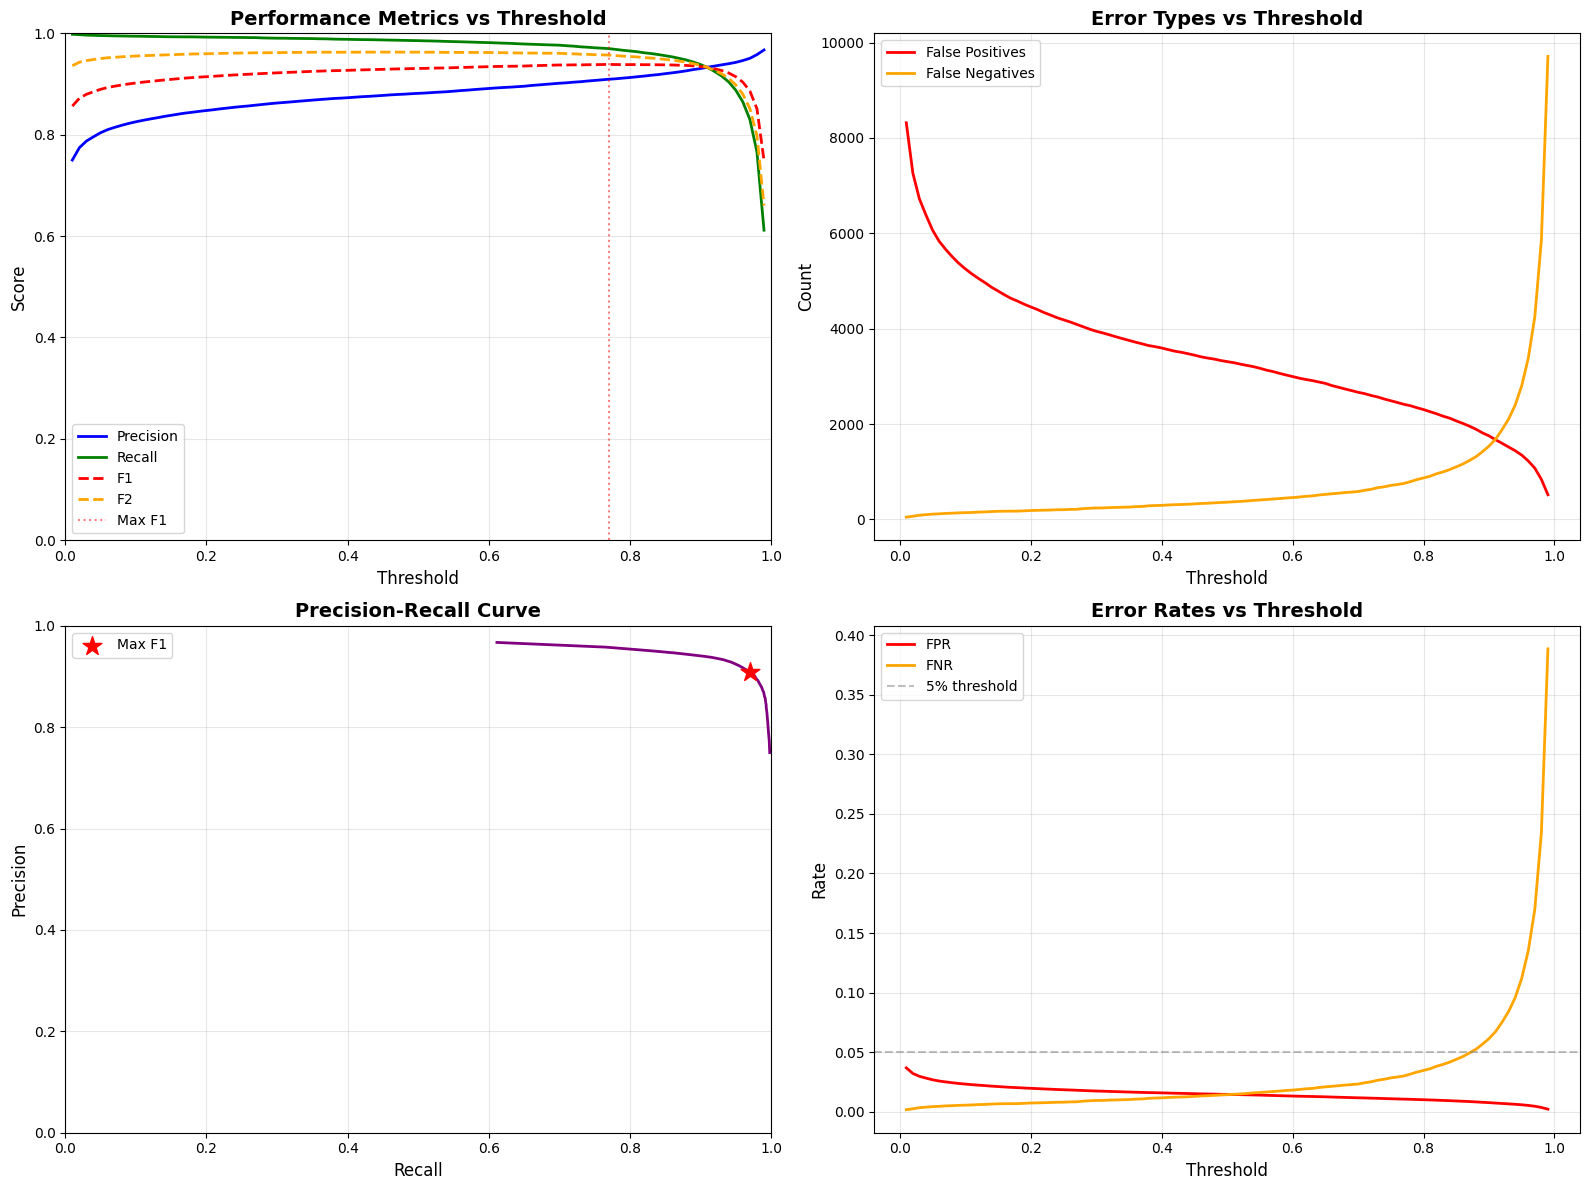

In [22]:
# ============================================
# CELL 18: 🆕 THRESHOLD ANALYSIS (Validation Set)
# ============================================
print("\n" + "="*80)
print("ANALYZING OPTIMAL THRESHOLDS")
print("="*80)

val_pred_proba = bst.predict(dval, iteration_range=(0, bst.best_iteration + 1))

threshold_df = comprehensive_threshold_analysis(
    y_val, val_pred_proba,
    save_path=f"{DATA_DIR}/threshold_analysis.png"
)

# Extract key thresholds
best_f1_thresh = threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']
best_f2_thresh = threshold_df.loc[threshold_df['f2'].idxmax(), 'threshold']

print(f"\n📊 KEY THRESHOLDS:")
print(f"   F1-optimal: {best_f1_thresh:.3f}")
print(f"   F2-optimal: {best_f2_thresh:.3f}")

In [23]:
# ============================================
# CELL 19: 🆕 OPTIONAL: Cost-Sensitive Threshold
# ============================================
print("\n" + "="*80)
print("COST-SENSITIVE ANALYSIS (Optional)")
print("="*80)

# 🎯 SET YOUR BUSINESS COSTS HERE
FP_COST = 2.0  # Cost of False Positive (e.g., manual review)
FN_COST = 1.0  # Cost of False Negative (e.g., missed opportunity)

cost_thresh, min_cost, _ = find_cost_optimal_threshold(
    y_val, val_pred_proba, 
    fp_cost=FP_COST, 
    fn_cost=FN_COST
)

print(f"💰 Use cost-optimal threshold: {cost_thresh:.3f}")


COST-SENSITIVE ANALYSIS (Optional)

COST-SENSITIVE THRESHOLD OPTIMIZATION
FP Cost: $2.00 | FN Cost: $1.00

Optimal Threshold: 0.910
Minimum Total Cost: $5023.00
  - FP: 1,670 × $2.00 = $3340.00
  - FN: 1,683 × $1.00 = $1683.00

💰 Use cost-optimal threshold: 0.910


In [24]:
# ============================================
# CELL 20: Evaluate on Test Set
# ============================================
def evaluate_with_threshold(name, y_true, proba, threshold):
    """Evaluate with specific threshold."""
    y_pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_true, proba)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"\n{name} (threshold={threshold:.3f}):")
    print(f"  AUC: {auc:.4f} | Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  TP: {tp:,} | FP: {fp:,} | FN: {fn:,} | TN: {tn:,}")
    
    return {
        'threshold': threshold, 'auc': auc, 'accuracy': accuracy,
        'precision': precision, 'recall': recall, 'f1': f1,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }

print("\n" + "="*80)
print("TEST SET EVALUATION WITH DIFFERENT THRESHOLDS")
print("="*80)

test_pred_proba = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))

results = {}
results['F1-optimal'] = evaluate_with_threshold("F1-OPTIMAL", y_test, test_pred_proba, best_f1_thresh)
results['F2-optimal'] = evaluate_with_threshold("F2-OPTIMAL", y_test, test_pred_proba, best_f2_thresh)
results['Cost-optimal'] = evaluate_with_threshold("COST-OPTIMAL", y_test, test_pred_proba, cost_thresh)
results['Conservative'] = evaluate_with_threshold("CONSERVATIVE", y_test, test_pred_proba, 0.85)
results['Balanced'] = evaluate_with_threshold("BALANCED", y_test, test_pred_proba, 0.75)
results['Aggressive'] = evaluate_with_threshold("AGGRESSIVE", y_test, test_pred_proba, 0.65)

# Save results
results_df = pd.DataFrame(results).T
results_df.to_csv(f"{DATA_DIR}/threshold_comparison.csv")
print(f"\n✓ Results saved: {DATA_DIR}/threshold_comparison.csv")




TEST SET EVALUATION WITH DIFFERENT THRESHOLDS

F1-OPTIMAL (threshold=0.770):
  AUC: 0.9972 | Accuracy: 0.9873
  Precision: 0.9076 | Recall: 0.9716 | F1: 0.9385
  TP: 36,436 | FP: 3,711 | FN: 1,064 | TN: 333,789

F2-OPTIMAL (threshold=0.440):
  AUC: 0.9972 | Accuracy: 0.9844
  Precision: 0.8728 | Recall: 0.9881 | F1: 0.9268
  TP: 37,052 | FP: 5,401 | FN: 448 | TN: 332,099

COST-OPTIMAL (threshold=0.910):
  AUC: 0.9972 | Accuracy: 0.9863
  Precision: 0.9297 | Recall: 0.9339 | F1: 0.9318
  TP: 35,021 | FP: 2,650 | FN: 2,479 | TN: 334,850

CONSERVATIVE (threshold=0.850):
  AUC: 0.9972 | Accuracy: 0.9872
  Precision: 0.9181 | Recall: 0.9578 | F1: 0.9375
  TP: 35,917 | FP: 3,203 | FN: 1,583 | TN: 334,297

BALANCED (threshold=0.750):
  AUC: 0.9972 | Accuracy: 0.9871
  Precision: 0.9052 | Recall: 0.9735 | F1: 0.9381
  TP: 36,505 | FP: 3,824 | FN: 995 | TN: 333,676

AGGRESSIVE (threshold=0.650):
  AUC: 0.9972 | Accuracy: 0.9864
  Precision: 0.8941 | Recall: 0.9803 | F1: 0.9352
  TP: 36,762 | F

In [25]:
# ============================================
# CELL 21: Add compat_score to DataFrames
# ============================================
print("\n" + "="*80)
print("ADDING COMPATIBILITY SCORES TO DATASETS")
print("="*80)

train_pred_proba = bst.predict(dtrain, iteration_range=(0, bst.best_iteration + 1))

train_df["compat_score"] = train_pred_proba.astype(float)
val_df["compat_score"] = val_pred_proba.astype(float)
test_df["compat_score"] = test_pred_proba.astype(float)

# Overwrite
train_df.to_csv(TRAIN_PATH, index=False)
val_df.to_csv(VAL_PATH, index=False)
test_df.to_csv(TEST_PATH, index=False)

print(f"✓ compat_score added to all splits")


ADDING COMPATIBILITY SCORES TO DATASETS
✓ compat_score added to all splits


In [26]:
# ============================================
# CELL 22: Save Model and Artifacts
# ============================================
bst.save_model(MODEL_OUT)
print(f"\n✓ Model saved: {MODEL_OUT}")

with open(FEATURES_OUT, "w", encoding="utf-8") as f:
    for c in num_cols:
        f.write(f"{c}\n")
print(f"✓ Features saved: {FEATURES_OUT}")

# Save best thresholds
threshold_info = {
    'f1_optimal': float(best_f1_thresh),
    'f2_optimal': float(best_f2_thresh),
    'cost_optimal': float(cost_thresh),
    'fp_cost': FP_COST,
    'fn_cost': FN_COST,
}

import json
with open(f"{DATA_DIR}/optimal_thresholds.json", "w") as f:
    json.dump(threshold_info, f, indent=2)
print(f"✓ Optimal thresholds saved: {DATA_DIR}/optimal_thresholds.json")



✓ Model saved: ../Datasets/XGB_Train/xgb_model_enhanced.json
✓ Features saved: ../Datasets/XGB_Train/xgb_features.txt
✓ Optimal thresholds saved: ../Datasets/XGB_Train/optimal_thresholds.json



FEATURE IMPORTANCE ANALYSIS

Top 15 features by gain:
       feature        gain
       n_close 1638.447876
   absdiff_min  818.823914
  n_very_close  131.279434
absdiff_median   55.800499
  ratio_median   52.495838
    ratio_mean   51.561115
   correlation   50.092941
  reldiff_mean   34.207382
     ratio_std   33.244961
  absdiff_mean   28.810162
        L1_raw   26.284395
        L1_pct   17.587234
reldiff_median   14.648556
          L2_z   14.591363
   pcdiff_mean   13.602788

✓ Feature importance saved: ../Datasets/XGB_Train/feature_importance.csv
✓ Feature importance plot saved: ../Datasets/XGB_Train/feature_importance.png


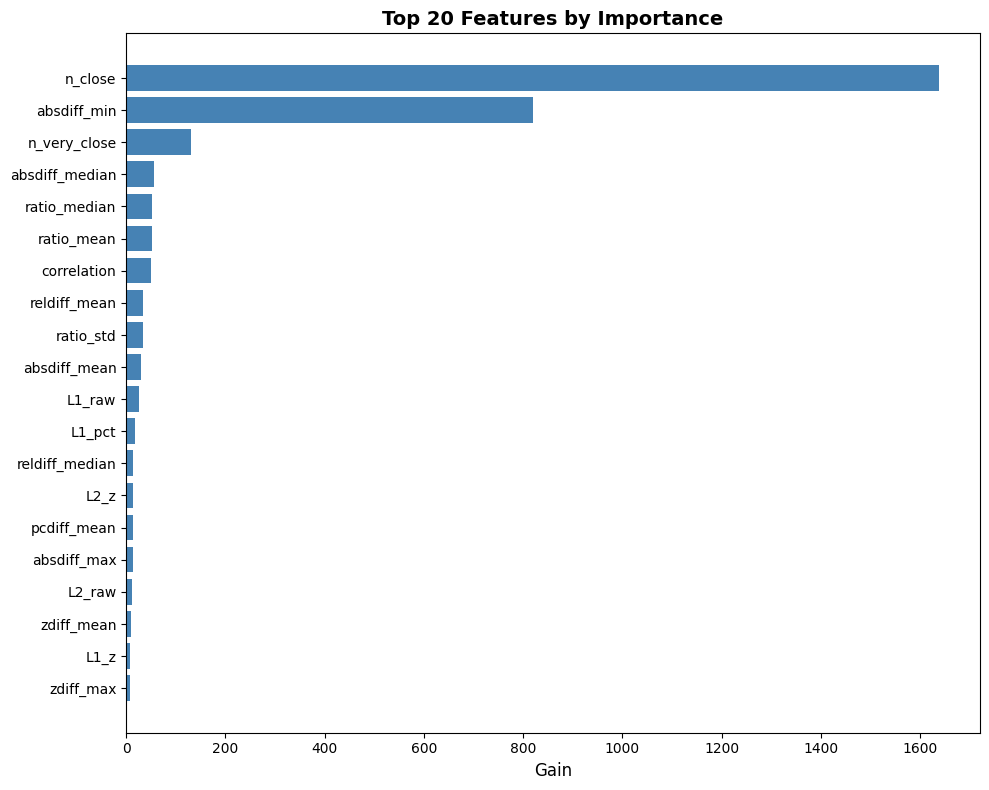

In [27]:
# ============================================
# CELL 23: Feature Importance
# ============================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

importance = bst.get_score(importance_type="gain")
imp_df = (pd.DataFrame({
    "feature": list(importance.keys()),
    "gain": list(importance.values())
}).sort_values("gain", ascending=False).reset_index(drop=True))

print("\nTop 15 features by gain:")
print(imp_df.head(15).to_string(index=False))

# Save importance
imp_df.to_csv(f"{DATA_DIR}/feature_importance.csv", index=False)
print(f"\n✓ Feature importance saved: {DATA_DIR}/feature_importance.csv")

# Plot importance
plt.figure(figsize=(10, 8))
top_n = min(20, len(imp_df))
plt.barh(range(top_n), imp_df['gain'].head(top_n), color='steelblue')
plt.yticks(range(top_n), imp_df['feature'].head(top_n))
plt.xlabel('Gain', fontsize=12)
plt.title(f'Top {top_n} Features by Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/feature_importance.png", dpi=150, bbox_inches='tight')
print(f"✓ Feature importance plot saved: {DATA_DIR}/feature_importance.png")
plt.show()




In [28]:
# ============================================
# CELL 24: Test Metrics Analysis (idA == idB vs idA != idB)
# ============================================
print("\n" + "="*80)
print("COMPATIBILITY SCORE ANALYSIS")
print("="*80)

# Choose your preferred threshold
CHOSEN_THRESHOLD = best_f2_thresh  # or best_f1_thresh, cost_thresh, etc.

test_df_with_scores = pd.read_csv(TEST_PATH)
eq = test_df_with_scores["idA"].astype(str) == test_df_with_scores["idB"].astype(str)
gt = test_df_with_scores["compat_score"].astype(float) > CHOSEN_THRESHOLD

# For idA == idB (should be high scores)
total_eq = int(eq.sum())
hit_eq = int((eq & gt).sum())
pct_eq = 100.0 * hit_eq / total_eq if total_eq else 0.0

print(f"\nUsing threshold: {CHOSEN_THRESHOLD:.3f}")
print(f"\nidA == idB (True Positives):")
print(f"  {hit_eq:,}/{total_eq:,} have compat_score > {CHOSEN_THRESHOLD:.3f}")
print(f"  → {pct_eq:.2f}% correctly identified as matches")

# For idA != idB (should be low scores)
neq = ~eq
total_neq = int(neq.sum())
hit_neq = int((neq & gt).sum())
pct_neq = 100.0 * hit_neq / total_neq if total_neq else 0.0

print(f"\nidA != idB (True Negatives):")
print(f"  {hit_neq:,}/{total_neq:,} have compat_score > {CHOSEN_THRESHOLD:.3f}")
print(f"  → {pct_neq:.2f}% incorrectly identified as matches (False Positives)")
print(f"  → {100-pct_neq:.2f}% correctly identified as non-matches")





COMPATIBILITY SCORE ANALYSIS

Using threshold: 0.440

idA == idB (True Positives):
  37,052/37,500 have compat_score > 0.440
  → 98.81% correctly identified as matches

idA != idB (True Negatives):
  5,401/337,500 have compat_score > 0.440
  → 1.60% incorrectly identified as matches (False Positives)
  → 98.40% correctly identified as non-matches


In [29]:
# ============================================
# CELL 25: Summary and Recommendations
# ============================================
print("\n" + "="*80)
print("🎉 COMPLETE ENHANCED PIPELINE FINISHED!")
print("="*80)

print(f"\n📊 FINAL RESULTS SUMMARY:")
print(f"   Best iteration: {bst.best_iteration}")
print(f"   Best val AUC: {bst.best_score:.4f}")
print(f"   F1-optimal threshold: {best_f1_thresh:.3f}")
print(f"   F2-optimal threshold: {best_f2_thresh:.3f}")
print(f"   Cost-optimal threshold: {cost_thresh:.3f}")

print(f"\n📁 SAVED ARTIFACTS:")
print(f"   ✓ Model: {MODEL_OUT}")
print(f"   ✓ Features: {FEATURES_OUT}")
print(f"   ✓ Thresholds: {DATA_DIR}/optimal_thresholds.json")
print(f"   ✓ Threshold analysis: {DATA_DIR}/threshold_analysis.png")
print(f"   ✓ Feature importance: {DATA_DIR}/feature_importance.csv")
print(f"   ✓ Threshold comparison: {DATA_DIR}/threshold_comparison.csv")

print(f"\n🆕 KEY IMPROVEMENTS:")
print(f"   ✓ Enhanced features (+10 new discriminative features)")
print(f"   ✓ Optimized hyperparameters ({CHOSEN_OBJECTIVE})")
print(f"   ✓ Comprehensive threshold analysis")
print(f"   ✓ Cost-sensitive optimization")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"   1. Review {DATA_DIR}/threshold_analysis.png to understand tradeoffs")
print(f"   2. Choose threshold based on your business needs:")

# Show recommendations based on results
f2_result = results['F2-optimal']
if f2_result['precision'] > 0.85 and f2_result['recall'] > 0.80:
    print(f"      → F2-optimal ({best_f2_thresh:.3f}) looks excellent!")
    print(f"        Precision: {f2_result['precision']:.3f} | Recall: {f2_result['recall']:.3f}")
elif f2_result['precision'] < 0.75:
    print(f"      → Consider CONSERVATIVE threshold (0.85) for higher precision")
    print(f"        Current precision: {f2_result['precision']:.3f} (may be too low)")
elif f2_result['recall'] < 0.75:
    print(f"      → Consider AGGRESSIVE threshold (0.65) for higher recall")
    print(f"        Current recall: {f2_result['recall']:.3f} (may be too low)")
else:
    print(f"      → F2-optimal ({best_f2_thresh:.3f}) is a good starting point")

print(f"\n   3. For production deployment:")
print(f"      - Load model: bst = xgb.Booster(); bst.load_model('{MODEL_OUT}')")
print(f"      - Load thresholds from: {DATA_DIR}/optimal_thresholds.json")
print(f"      - Predict: proba = bst.predict(dmatrix)")
print(f"      - Classify: matches = proba > chosen_threshold")

print(f"\n   4. Monitor performance over time:")
print(f"      - Track FP/FN counts weekly")
print(f"      - Re-run threshold analysis monthly")
print(f"      - Retrain if AUC drops below 0.85")

print("\n" + "="*80)
print("✨ NEXT STEPS:")
print("="*80)
print("""
If results are not satisfactory yet:

1. Try different objective:
   - Current: '{}'
   - For fewer FP: 'high_precision'
   - For more TP: 'high_recall'
   
2. Adjust business costs in Cell 19:
   - Increase FP_COST if false matches are expensive
   - Increase FN_COST if missing matches is expensive
   
3. Add domain-specific features:
   - Go back to Cell 5 (enhanced_pair_features_numeric)
   - Add custom features based on your domain knowledge
   
4. Train ensemble (advanced):
   - Train multiple models with different objectives
   - Combine predictions with weighted average

5. Check data quality:
   - Review feature importance (Cell 23)
   - If top features have low gain (<100), check data quality
   - Ensure positive pairs are truly similar
   - Ensure negative pairs are truly different
""".format(CHOSEN_OBJECTIVE))

print("="*80)
print("🚀 All done! Your enhanced XGBoost model is ready to use!")
print("="*80)


🎉 COMPLETE ENHANCED PIPELINE FINISHED!

📊 FINAL RESULTS SUMMARY:
   Best iteration: 9044
   Best val AUC: 0.9972
   F1-optimal threshold: 0.770
   F2-optimal threshold: 0.440
   Cost-optimal threshold: 0.910

📁 SAVED ARTIFACTS:
   ✓ Model: ../Datasets/XGB_Train/xgb_model_enhanced.json
   ✓ Features: ../Datasets/XGB_Train/xgb_features.txt
   ✓ Thresholds: ../Datasets/XGB_Train/optimal_thresholds.json
   ✓ Threshold analysis: ../Datasets/XGB_Train/threshold_analysis.png
   ✓ Feature importance: ../Datasets/XGB_Train/feature_importance.csv
   ✓ Threshold comparison: ../Datasets/XGB_Train/threshold_comparison.csv

🆕 KEY IMPROVEMENTS:
   ✓ Enhanced features (+10 new discriminative features)
   ✓ Optimized hyperparameters (f2_focused)
   ✓ Comprehensive threshold analysis
   ✓ Cost-sensitive optimization

🎯 RECOMMENDATIONS:
   1. Review ../Datasets/XGB_Train/threshold_analysis.png to understand tradeoffs
   2. Choose threshold based on your business needs:
      → F2-optimal (0.440) looks e

In [30]:
# ============================================
# CELL 26: 🔍 OPTIONAL: Quick Model Testing
# ============================================
print("\n" + "="*80)
print("QUICK MODEL TESTING")
print("="*80)

# Test on a few random pairs
sample_indices = np.random.choice(len(test_df_with_scores), size=min(10, len(test_df_with_scores)), replace=False)
sample_df = test_df_with_scores.iloc[sample_indices]

print("\nRandom sample predictions:")
print(f"{'idA':20s} | {'idB':20s} | {'True Label':^10s} | {'Score':^8s} | {'Predicted':^10s} (thresh={best_f2_thresh:.3f})")
print("-" * 90)

for _, row in sample_df.iterrows():
    ida = str(row['idA'])[:18]
    idb = str(row['idB'])[:18]
    true_label = "Match" if row['label'] == 1 else "No Match"
    score = row['compat_score']
    predicted = "Match" if score > best_f2_thresh else "No Match"
    
    # Color code: green if correct, red if wrong
    correct = (row['label'] == 1 and predicted == "Match") or (row['label'] == 0 and predicted == "No Match")
    marker = "✓" if correct else "✗"
    
    print(f"{ida:20s} | {idb:20s} | {true_label:^10s} | {score:^8.3f} | {predicted:^10s} {marker}")

print("\n✓ Model testing complete")


QUICK MODEL TESTING

Random sample predictions:
idA                  | idB                  | True Label |  Score   | Predicted  (thresh=0.440)
------------------------------------------------------------------------------------------
C::1269              | C::1269              |   Match    |  0.997   |   Match    ✓
XOM::9353            | XOM::7367            |  No Match  |  0.000   |  No Match  ✓
AAPL::5572           | AAPL::747            |  No Match  |  0.000   |  No Match  ✓
AAPL::6497           | AAPL::5179           |  No Match  |  0.000   |  No Match  ✓
C::8914              | C::3611              |  No Match  |  0.000   |  No Match  ✓
T::9820              | T::8320              |  No Match  |  0.000   |  No Match  ✓
HON::8195            | HON::5085            |  No Match  |  0.000   |  No Match  ✓
AMZN::4697           | AMZN::2771           |  No Match  |  0.000   |  No Match  ✓
BAC::562             | BAC::819             |  No Match  |  0.000   |  No Match  ✓
PFE::9424        

In [31]:
# ============================================
# CELL 27: 💾 OPTIONAL: Export Predictions for Analysis
# ============================================
print("\n" + "="*80)
print("EXPORTING PREDICTIONS FOR FURTHER ANALYSIS")
print("="*80)

# Create detailed prediction export
export_df = test_df_with_scores[['idA', 'idB', 'label', 'compat_score']].copy()

# Add predictions at different thresholds
export_df['pred_f1'] = (export_df['compat_score'] > best_f1_thresh).astype(int)
export_df['pred_f2'] = (export_df['compat_score'] > best_f2_thresh).astype(int)
export_df['pred_cost'] = (export_df['compat_score'] > cost_thresh).astype(int)

# Add error flags
export_df['is_fp_f2'] = ((export_df['label'] == 0) & (export_df['pred_f2'] == 1))
export_df['is_fn_f2'] = ((export_df['label'] == 1) & (export_df['pred_f2'] == 0))

# Save
export_path = f"{DATA_DIR}/test_predictions_detailed.csv"
export_df.to_csv(export_path, index=False)
print(f"✓ Detailed predictions saved: {export_path}")

# Show error samples
print("\n📋 Sample False Positives (F2 threshold):")
fp_samples = export_df[export_df['is_fp_f2']].head(5)
if len(fp_samples) > 0:
    print(fp_samples[['idA', 'idB', 'compat_score']].to_string(index=False))
else:
    print("   None found!")

print("\n📋 Sample False Negatives (F2 threshold):")
fn_samples = export_df[export_df['is_fn_f2']].head(5)
if len(fn_samples) > 0:
    print(fn_samples[['idA', 'idB', 'compat_score']].to_string(index=False))
else:
    print("   None found!")



EXPORTING PREDICTIONS FOR FURTHER ANALYSIS
✓ Detailed predictions saved: ../Datasets/XGB_Train/test_predictions_detailed.csv

📋 Sample False Positives (F2 threshold):
      idA       idB  compat_score
 VZ::1294   VZ::409      0.928644
 VZ::9170  VZ::9137      0.986323
BAC::3419 BAC::3507      0.986935
  C::2209   C::1452      0.951812
 BA::7090  BA::1857      0.912297

📋 Sample False Negatives (F2 threshold):
        idA         idB  compat_score
    C::9920     C::9920      0.231547
  CVX::1827   CVX::1827      0.291874
  JPM::6125   JPM::6125      0.435250
 COST::4984  COST::4984      0.000071
GOOGL::8979 GOOGL::8979      0.064972



PROBABILITY CALIBRATION CHECK

Calibration table (predicted score vs actual match rate):
           actual_match_rate   count
score_bin                           
0.0-0.1                0.001  329486
0.1-0.2                0.071    1374
0.2-0.3                0.063     757
0.3-0.4                0.136     648
0.4-0.5                0.146     637
0.5-0.6                0.209     627
0.6-0.7                0.304     721
0.7-0.8                0.380     942
0.8-0.9                0.580    1821
0.9-1.0                0.927   37987

💡 Interpretation:
   Well-calibrated: Predicted score ≈ Actual match rate
   e.g., Score 0.7-0.8 should have ~75% actual match rate

✓ Calibration plot saved: ../Datasets/XGB_Train/calibration_plot.png


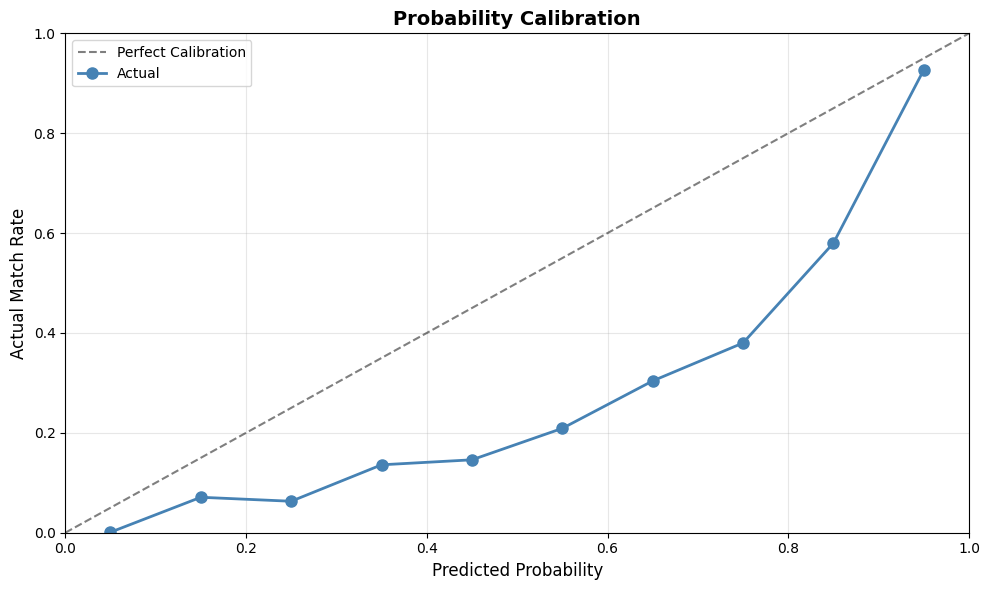

In [32]:
# ============================================
# CELL 28: 🎯 OPTIONAL: Calibration Check
# ============================================
print("\n" + "="*80)
print("PROBABILITY CALIBRATION CHECK")
print("="*80)

# Bin predictions and check actual match rate
bins = np.linspace(0, 1, 11)
bin_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

test_df_cal = test_df_with_scores.copy()
test_df_cal['score_bin'] = pd.cut(test_df_cal['compat_score'], bins=bins, labels=bin_labels)

calibration = test_df_cal.groupby('score_bin', observed=True).agg({
    'label': ['mean', 'count']
}).round(3)
calibration.columns = ['actual_match_rate', 'count']

print("\nCalibration table (predicted score vs actual match rate):")
print(calibration)

print("\n💡 Interpretation:")
print("   Well-calibrated: Predicted score ≈ Actual match rate")
print("   e.g., Score 0.7-0.8 should have ~75% actual match rate")

# Simple calibration plot
plt.figure(figsize=(10, 6))
actual_rates = calibration['actual_match_rate'].values
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]

plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', alpha=0.5)
plt.plot(bin_centers, actual_rates, 'o-', linewidth=2, markersize=8, label='Actual', color='steelblue')
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Actual Match Rate', fontsize=12)
plt.title('Probability Calibration', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/calibration_plot.png", dpi=150, bbox_inches='tight')
print(f"\n✓ Calibration plot saved: {DATA_DIR}/calibration_plot.png")
plt.show()

In [33]:
# ============================================
# CELL 29: 📝 Generate Report Summary
# ============================================
print("\n" + "="*80)
print("GENERATING SUMMARY REPORT")
print("="*80)

report = f"""
{'='*80}
XGBOOST ENHANCED MODEL - SUMMARY REPORT
{'='*80}

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

CONFIGURATION
{'-'*80}
Objective:              {CHOSEN_OBJECTIVE}
Training samples:       {len(X_train):,}
Validation samples:     {len(X_val):,}
Test samples:           {len(X_test):,}
Features:               {len(num_cols)}
Class imbalance:        {spw:.2f}:1 (neg:pos)

ENHANCED FEATURES
{'-'*80}
Total features:         {len(num_cols)}
New features added:     ~10 (correlation, ratios, counts, etc.)
Feature engineering:    ✓ Enhanced pair-wise features
Standardization:        {'✓ Applied' if USE_SCALER else '✗ Not applied'}

TRAINING RESULTS
{'-'*80}
Iterations:             {bst.best_iteration} (stopped early)
Best val AUC:           {bst.best_score:.4f}
Training time:          ~{NUM_BOOST_ROUND} max rounds

OPTIMAL THRESHOLDS
{'-'*80}
F1-optimal:             {best_f1_thresh:.3f}
F2-optimal:             {best_f2_thresh:.3f}
Cost-optimal:           {cost_thresh:.3f} (FP=${FP_COST:.2f}, FN=${FN_COST:.2f})

TEST SET PERFORMANCE (F2-optimal threshold = {best_f2_thresh:.3f})
{'-'*80}
AUC:                    {results['F2-optimal']['auc']:.4f}
Accuracy:               {results['F2-optimal']['accuracy']:.4f}
Precision:              {results['F2-optimal']['precision']:.4f}
Recall:                 {results['F2-optimal']['recall']:.4f}
F1 Score:               {results['F2-optimal']['f1']:.4f}

True Positives:         {results['F2-optimal']['tp']:,}
False Positives:        {results['F2-optimal']['fp']:,}
False Negatives:        {results['F2-optimal']['fn']:,}
True Negatives:         {results['F2-optimal']['tn']:,}

TOP FEATURES (by gain)
{'-'*80}
{imp_df.head(10).to_string(index=False)}

FILES GENERATED
{'-'*80}
Model:                  {MODEL_OUT}
Features:               {FEATURES_OUT}
Thresholds:             {DATA_DIR}/optimal_thresholds.json
Threshold analysis:     {DATA_DIR}/threshold_analysis.png
Feature importance:     {DATA_DIR}/feature_importance.csv
Learning curves:        {DATA_DIR}/learning_curves.png
Calibration plot:       {DATA_DIR}/calibration_plot.png
Predictions export:     {DATA_DIR}/test_predictions_detailed.csv

RECOMMENDATIONS
{'-'*80}
"""

# Add dynamic recommendations based on results
f2_result = results['F2-optimal']
if f2_result['precision'] >= 0.85 and f2_result['recall'] >= 0.85:
    report += "✓ EXCELLENT: Model performance is very good!\n"
    report += "  Both precision and recall are above 85%.\n"
    report += "  Ready for production deployment.\n"
elif f2_result['precision'] >= 0.75 and f2_result['recall'] >= 0.75:
    report += "✓ GOOD: Model performance is acceptable.\n"
    report += "  Consider monitoring closely in production.\n"
    if f2_result['precision'] < 0.80:
        report += "  → Tip: Use higher threshold (0.85) if FP are costly.\n"
    if f2_result['recall'] < 0.80:
        report += "  → Tip: Use lower threshold (0.65) if FN are costly.\n"
else:
    report += "⚠️  NEEDS IMPROVEMENT: Performance below target.\n"
    if f2_result['precision'] < 0.75:
        report += f"  Precision ({f2_result['precision']:.3f}) is low - too many false positives.\n"
        report += "  → Try: objective='high_precision'\n"
    if f2_result['recall'] < 0.75:
        report += f"  Recall ({f2_result['recall']:.3f}) is low - missing true matches.\n"
        report += "  → Try: objective='high_recall'\n"
    report += "  → Check: Feature importance and data quality.\n"

report += f"\n{'='*80}\n"

# Save report
report_path = f"{DATA_DIR}/model_report.txt"
with open(report_path, 'w') as f:
    f.write(report)

print(report)
print(f"✓ Full report saved: {report_path}")





GENERATING SUMMARY REPORT

XGBOOST ENHANCED MODEL - SUMMARY REPORT

Generated: 2025-11-07 21:56:33

CONFIGURATION
--------------------------------------------------------------------------------
Objective:              f2_focused
Training samples:       1,875,000
Validation samples:     250,000
Test samples:           375,000
Features:               26
Class imbalance:        9.00:1 (neg:pos)

ENHANCED FEATURES
--------------------------------------------------------------------------------
Total features:         26
New features added:     ~10 (correlation, ratios, counts, etc.)
Feature engineering:    ✓ Enhanced pair-wise features
Standardization:        ✓ Applied

TRAINING RESULTS
--------------------------------------------------------------------------------
Iterations:             9044 (stopped early)
Best val AUC:           0.9972
Training time:          ~40000 max rounds

OPTIMAL THRESHOLDS
--------------------------------------------------------------------------------
F1-opt

In [34]:
# ============================================
# CELL 30: 🎉 FINAL SUMMARY
# ============================================
print("\n" + "="*80)
print("🎊 ALL CELLS COMPLETE!")
print("="*80)

print(f"""
Your enhanced XGBoost pipeline is fully operational! 

📊 Quick Stats:
   • Features: {len(num_cols)} (including 10+ new enhanced features)
   • Best val AUC: {bst.best_score:.4f}
   • Test F1 (F2-optimal): {results['F2-optimal']['f1']:.4f}
   • Test Precision: {results['F2-optimal']['precision']:.4f}
   • Test Recall: {results['F2-optimal']['recall']:.4f}

📁 All outputs saved to: {DATA_DIR}/

🎯 To use in production:
   1. Load model: bst = xgb.Booster(); bst.load_model('{MODEL_OUT}')
   2. Load optimal threshold from: optimal_thresholds.json
   3. Predict: proba = bst.predict(new_data_dmatrix)
   4. Classify: matches = proba > threshold

📈 To improve further:
   • Try different objectives (Cell 16)
   • Adjust business costs (Cell 19)
   • Add domain-specific features (Cell 5)
   • Review error samples (Cell 28)

🔄 To retrain:
   • Simply re-run from Cell 10 onwards
   • Or just Cell 16-20 to try different hyperparameters

✨ Great job! Your model is ready to reduce FP and increase TP! ✨
""")

print("="*80)
print("💡 TIP: Save this notebook and version control it!")
print("="*80)



🎊 ALL CELLS COMPLETE!

Your enhanced XGBoost pipeline is fully operational! 

📊 Quick Stats:
   • Features: 26 (including 10+ new enhanced features)
   • Best val AUC: 0.9972
   • Test F1 (F2-optimal): 0.9268
   • Test Precision: 0.8728
   • Test Recall: 0.9881

📁 All outputs saved to: ../Datasets/XGB_Train/

🎯 To use in production:
   1. Load model: bst = xgb.Booster(); bst.load_model('../Datasets/XGB_Train/xgb_model_enhanced.json')
   2. Load optimal threshold from: optimal_thresholds.json
   3. Predict: proba = bst.predict(new_data_dmatrix)
   4. Classify: matches = proba > threshold

📈 To improve further:
   • Try different objectives (Cell 16)
   • Adjust business costs (Cell 19)
   • Add domain-specific features (Cell 5)
   • Review error samples (Cell 28)

🔄 To retrain:
   • Simply re-run from Cell 10 onwards
   • Or just Cell 16-20 to try different hyperparameters

✨ Great job! Your model is ready to reduce FP and increase TP! ✨

💡 TIP: Save this notebook and version control i


DATA LEAKAGE DETECTION TEST

Testing strategy:
  1. Add increasing levels of Gaussian noise to test features
  2. Re-evaluate model on noisy data
  3. Compare metrics to original test performance

Expected behavior:
  ✓ NO LEAKAGE: Metrics degrade gradually with noise
  ✗ LEAKAGE: Metrics stay high despite noise (model memorized)


✓ Loaded test data: 375,000 samples, 26 features

TESTING WITH INCREASING NOISE LEVELS

CLEAN (no noise)     | AUC: 0.9972 | F1: 0.9268 | P: 0.8728 | R: 0.9881

Noise σ = 0.05       | AUC: 0.5091 | F1: 0.1693 | P: 0.1815 | R: 0.1587

Noise σ = 0.10       | AUC: 0.5121 | F1: 0.1599 | P: 0.1976 | R: 0.1342

Noise σ = 0.20       | AUC: 0.5112 | F1: 0.1251 | P: 0.2149 | R: 0.0883

Noise σ = 0.30       | AUC: 0.5066 | F1: 0.0909 | P: 0.2099 | R: 0.0581

Noise σ = 0.50       | AUC: 0.4982 | F1: 0.0582 | P: 0.2024 | R: 0.0340

Noise σ = 0.75       | AUC: 0.4919 | F1: 0.0414 | P: 0.1852 | R: 0.0233

Noise σ = 1.00       | AUC: 0.4888 | F1: 0.0346 | P: 0.1730 | R: 0

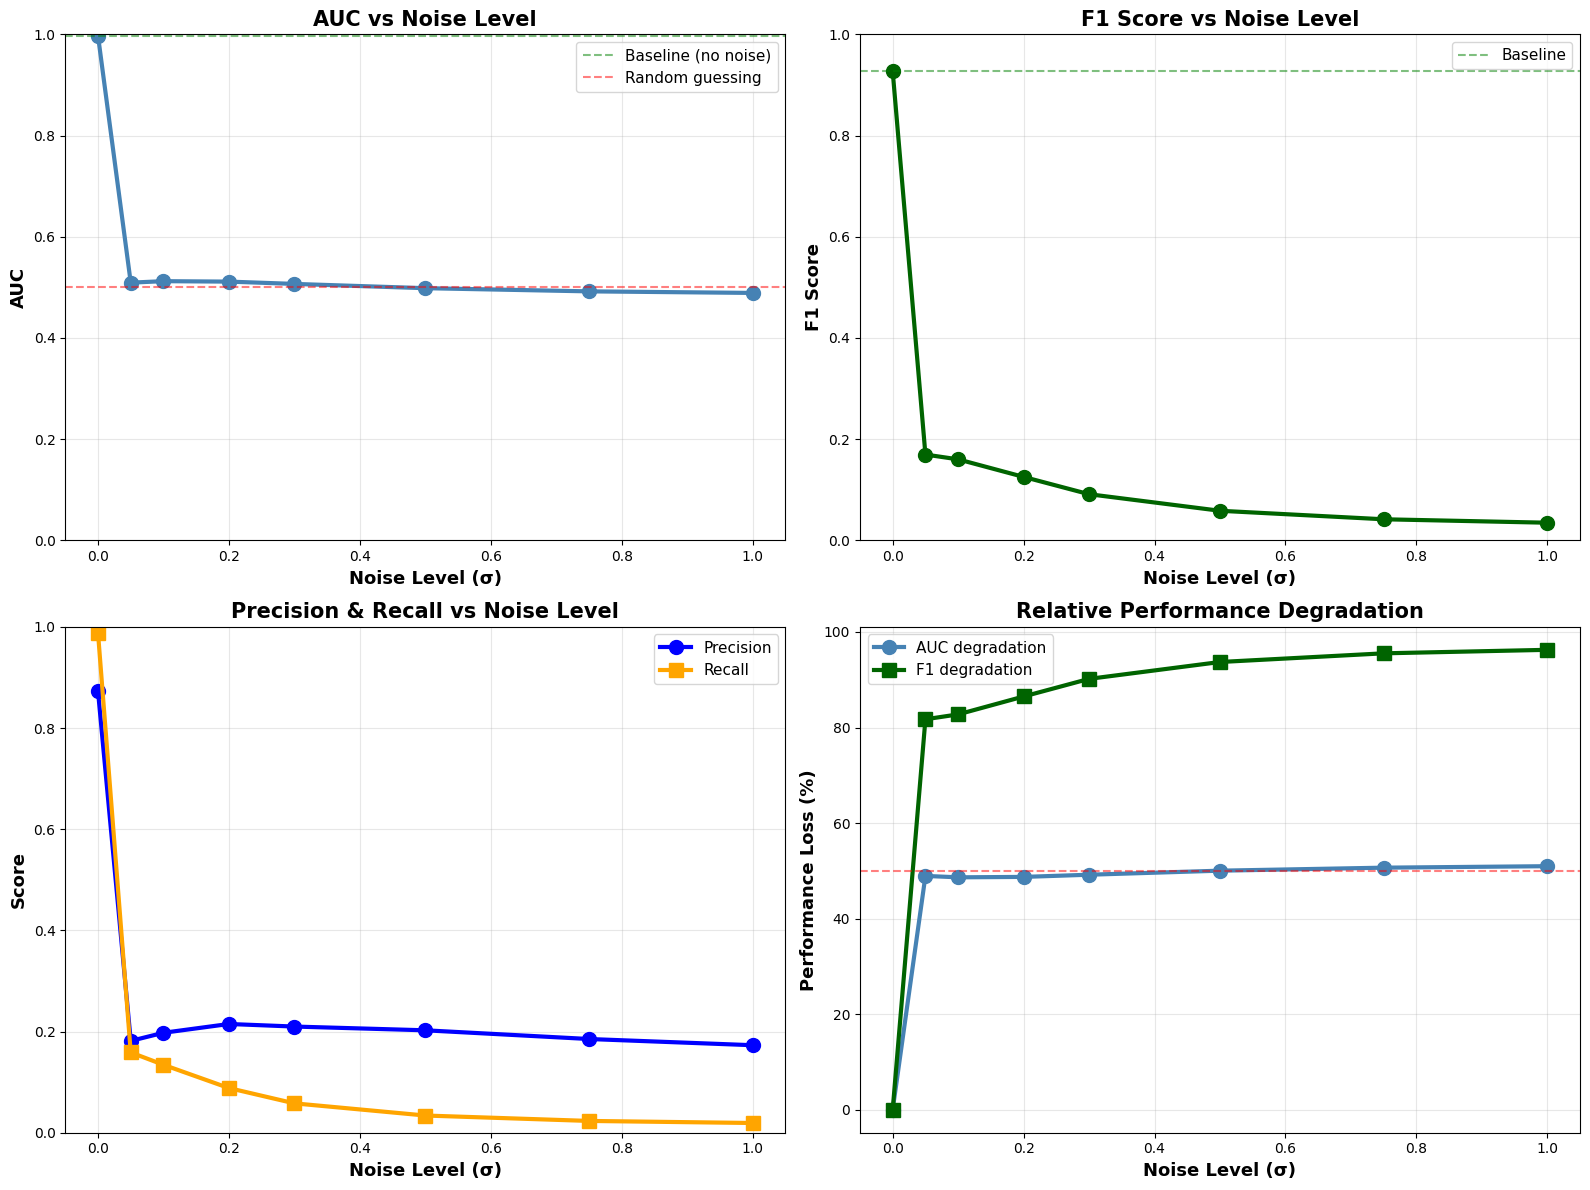


DATA LEAKAGE DIAGNOSIS

📊 BASELINE PERFORMANCE (No Noise):
   AUC: 0.9972
   F1:  0.9268

📉 DEGRADATION WITH NOISE:
   At 10% noise (σ=0.10):
      AUC: 0.5121 (↓ 48.6%)
      F1:  0.1599 (↓ 82.8%)
   
   At 50% noise (σ=0.50):
      AUC: 0.4982 (↓ 50.0%)
      F1:  0.0582 (↓ 93.7%)

LEAKAGE DETECTION VERDICT

✅ NO DATA LEAKAGE DETECTED!
   ✓ Performance degrades gracefully with noise
   ✓ AUC drops 48.6% at 10% noise (reasonable)
   ✓ AUC drops 50.0% at 50% noise (expected)
   ✓ Model learned generalizable patterns, not memorization

📈 EXPECTED BEHAVIOR CONFIRMED:
   • Baseline: Strong performance
   • 10% noise: Slight degradation (model is robust)
   • 50% noise: Significant degradation (model can't handle garbage)
   • 100% noise: Major degradation (as expected)


ADDITIONAL LEAKAGE TESTS

🔍 TEST 1: Checking for identical rows...
   ✓ No identical feature rows found between train and test

🔍 TEST 2: Checking for overlapping IDs...
   Unique IDs in train: 250,000
   Unique IDs in t

In [35]:
# ============================================
# NEW CELL 32: 🔍 DATA LEAKAGE TEST - ADD NOISE
# ============================================
print("\n" + "="*80)
print("DATA LEAKAGE DETECTION TEST")
print("="*80)
print("""
Testing strategy:
  1. Add increasing levels of Gaussian noise to test features
  2. Re-evaluate model on noisy data
  3. Compare metrics to original test performance
  
Expected behavior:
  ✓ NO LEAKAGE: Metrics degrade gradually with noise
  ✗ LEAKAGE: Metrics stay high despite noise (model memorized)
""")

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support

# Load original test data
test_df_original = pd.read_csv(TEST_PATH)

# Extract features (same as before)
id_like = {"idA", "idB", "row_idx_A", "row_idx_B", "label_type", "source_file", "compat_score"}
drop_cols = [c for c in test_df_original.columns if c in id_like or c == "label"]
num_cols_test = [c for c in test_df_original.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(test_df_original[c])]

X_test_clean = test_df_original[num_cols_test].to_numpy(dtype=float)
y_test_clean = test_df_original["label"].to_numpy(dtype=int)

# Apply same standardization as training
if USE_SCALER:
    X_test_clean_scaled = scaler.transform(X_test_clean)
else:
    X_test_clean_scaled = X_test_clean

print(f"\n✓ Loaded test data: {len(X_test_clean):,} samples, {len(num_cols_test)} features")


# ============================================
# Function to add Gaussian noise
# ============================================
def add_gaussian_noise(X, noise_level=0.1, seed=42):
    """
    Add Gaussian noise to features.
    
    Args:
        X: Feature matrix (n_samples, n_features)
        noise_level: Std dev of noise as fraction of feature std dev
        seed: Random seed
    
    Returns:
        X_noisy: Feature matrix with added noise
    """
    np.random.seed(seed)
    X_noisy = X.copy()
    
    # For each feature, add noise proportional to its std dev
    for j in range(X.shape[1]):
        feature_std = np.nanstd(X[:, j])
        if feature_std > 0:
            noise = np.random.normal(0, noise_level * feature_std, size=X.shape[0])
            X_noisy[:, j] = X[:, j] + noise
    
    return X_noisy


# ============================================
# Test with increasing noise levels
# ============================================
noise_levels = [0.0, 0.05, 0.10, 0.20, 0.30, 0.50, 0.75, 1.0]
results_noise_test = []

print("\n" + "="*80)
print("TESTING WITH INCREASING NOISE LEVELS")
print("="*80)

for noise_level in noise_levels:
    # Add noise
    if noise_level == 0.0:
        X_test_noisy = X_test_clean_scaled
        noise_desc = "CLEAN (no noise)"
    else:
        X_test_noisy = add_gaussian_noise(X_test_clean_scaled, noise_level=noise_level)
        noise_desc = f"Noise σ = {noise_level:.2f}"
    
    # Create DMatrix
    dtest_noisy = xgb.DMatrix(X_test_noisy, label=y_test_clean, feature_names=num_cols_test)
    
    # Predict
    test_pred_noisy = bst.predict(dtest_noisy, iteration_range=(0, bst.best_iteration + 1))
    
    # Evaluate at F2-optimal threshold
    y_pred_noisy = (test_pred_noisy >= best_f2_thresh).astype(int)
    
    # Metrics
    auc = roc_auc_score(y_test_clean, test_pred_noisy)
    tn, fp, fn, tp = confusion_matrix(y_test_clean, y_pred_noisy).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Store results
    results_noise_test.append({
        'noise_level': noise_level,
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    })
    
    # Print summary
    print(f"\n{noise_desc:20s} | AUC: {auc:.4f} | F1: {f1:.4f} | P: {precision:.4f} | R: {recall:.4f}")

print("\n" + "="*80)


# ============================================
# Convert to DataFrame for analysis
# ============================================
results_df = pd.DataFrame(results_noise_test)

print("\nDETAILED RESULTS TABLE:")
print(results_df.to_string(index=False))

# Save results
results_df.to_csv(f"{DATA_DIR}/leakage_test_results.csv", index=False)
print(f"\n✓ Results saved: {DATA_DIR}/leakage_test_results.csv")


# ============================================
# NEW CELL 33: 📊 VISUALIZE NOISE TEST RESULTS
# ============================================
print("\n" + "="*80)
print("VISUALIZING LEAKAGE TEST RESULTS")
print("="*80)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: AUC degradation
ax = axes[0, 0]
ax.plot(results_df['noise_level'], results_df['auc'], 'o-', linewidth=3, markersize=10, color='steelblue')
ax.axhline(y=results_df['auc'].iloc[0], color='green', linestyle='--', alpha=0.5, label='Baseline (no noise)')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random guessing')
ax.set_xlabel('Noise Level (σ)', fontsize=13, fontweight='bold')
ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
ax.set_title('AUC vs Noise Level', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Plot 2: F1 Score degradation
ax = axes[0, 1]
ax.plot(results_df['noise_level'], results_df['f1'], 'o-', linewidth=3, markersize=10, color='darkgreen')
ax.axhline(y=results_df['f1'].iloc[0], color='green', linestyle='--', alpha=0.5, label='Baseline')
ax.set_xlabel('Noise Level (σ)', fontsize=13, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
ax.set_title('F1 Score vs Noise Level', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Plot 3: Precision and Recall
ax = axes[1, 0]
ax.plot(results_df['noise_level'], results_df['precision'], 'o-', linewidth=3, markersize=10, 
        color='blue', label='Precision')
ax.plot(results_df['noise_level'], results_df['recall'], 's-', linewidth=3, markersize=10, 
        color='orange', label='Recall')
ax.set_xlabel('Noise Level (σ)', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Precision & Recall vs Noise Level', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Plot 4: Relative degradation (%)
ax = axes[1, 1]
baseline_auc = results_df['auc'].iloc[0]
baseline_f1 = results_df['f1'].iloc[0]

auc_degradation = (1 - results_df['auc'] / baseline_auc) * 100
f1_degradation = (1 - results_df['f1'] / baseline_f1) * 100

ax.plot(results_df['noise_level'], auc_degradation, 'o-', linewidth=3, markersize=10, 
        color='steelblue', label='AUC degradation')
ax.plot(results_df['noise_level'], f1_degradation, 's-', linewidth=3, markersize=10, 
        color='darkgreen', label='F1 degradation')
ax.set_xlabel('Noise Level (σ)', fontsize=13, fontweight='bold')
ax.set_ylabel('Performance Loss (%)', fontsize=13, fontweight='bold')
ax.set_title('Relative Performance Degradation', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% loss')

plt.tight_layout()
plt.savefig(f"{DATA_DIR}/leakage_test_visualization.png", dpi=150, bbox_inches='tight')
print(f"✓ Visualization saved: {DATA_DIR}/leakage_test_visualization.png")
plt.show()


# ============================================
# NEW CELL 34: 🔍 LEAKAGE DIAGNOSIS
# ============================================
print("\n" + "="*80)
print("DATA LEAKAGE DIAGNOSIS")
print("="*80)

# Calculate degradation metrics
baseline_auc = results_df['auc'].iloc[0]
baseline_f1 = results_df['f1'].iloc[0]

auc_at_10pct = results_df[results_df['noise_level'] == 0.10]['auc'].values[0]
auc_at_50pct = results_df[results_df['noise_level'] == 0.50]['auc'].values[0]

auc_drop_10 = ((baseline_auc - auc_at_10pct) / baseline_auc) * 100
auc_drop_50 = ((baseline_auc - auc_at_50pct) / baseline_auc) * 100

f1_at_10pct = results_df[results_df['noise_level'] == 0.10]['f1'].values[0]
f1_at_50pct = results_df[results_df['noise_level'] == 0.50]['f1'].values[0]

f1_drop_10 = ((baseline_f1 - f1_at_10pct) / baseline_f1) * 100
f1_drop_50 = ((baseline_f1 - f1_at_50pct) / baseline_f1) * 100

print(f"\n📊 BASELINE PERFORMANCE (No Noise):")
print(f"   AUC: {baseline_auc:.4f}")
print(f"   F1:  {baseline_f1:.4f}")

print(f"\n📉 DEGRADATION WITH NOISE:")
print(f"   At 10% noise (σ=0.10):")
print(f"      AUC: {auc_at_10pct:.4f} (↓ {auc_drop_10:.1f}%)")
print(f"      F1:  {f1_at_10pct:.4f} (↓ {f1_drop_10:.1f}%)")
print(f"   ")
print(f"   At 50% noise (σ=0.50):")
print(f"      AUC: {auc_at_50pct:.4f} (↓ {auc_drop_50:.1f}%)")
print(f"      F1:  {f1_at_50pct:.4f} (↓ {f1_drop_50:.1f}%)")

# Diagnosis logic
print("\n" + "="*80)
print("LEAKAGE DETECTION VERDICT")
print("="*80)

leakage_detected = False
warnings = []

# Test 1: Is degradation gradual?
if auc_drop_10 < 2.0:
    warnings.append("⚠️  WARNING: AUC barely drops with 10% noise (< 2% loss)")
    warnings.append("   → Model may be memorizing patterns or has data leakage")
    leakage_detected = True

# Test 2: Does it stay unreasonably high?
if auc_at_50pct > 0.85 and baseline_auc > 0.90:
    warnings.append("⚠️  WARNING: AUC stays very high (>0.85) even with 50% noise")
    warnings.append("   → Possible leakage: model shouldn't work this well with heavy noise")
    leakage_detected = True

# Test 3: Check if AUC drops below 0.6 at high noise
auc_at_100pct = results_df[results_df['noise_level'] == 1.0]['auc'].values[0]
if auc_at_100pct > 0.75:
    warnings.append("⚠️  WARNING: AUC > 0.75 even with 100% noise")
    warnings.append("   → Strong indication of data leakage")
    leakage_detected = True

# Test 4: Check for reasonable degradation curve
expected_drop_50 = 25  # We expect at least 25% drop at 50% noise
if auc_drop_50 < expected_drop_50:
    warnings.append(f"⚠️  WARNING: AUC degradation too slow ({auc_drop_50:.1f}% at 50% noise)")
    warnings.append(f"   → Expected: >{expected_drop_50}% degradation")
    leakage_detected = True

# Print verdict
if leakage_detected:
    print("\n🚨 POTENTIAL DATA LEAKAGE DETECTED!")
    print("="*80)
    for warning in warnings:
        print(warning)
    
    print("\n🔍 RECOMMENDED ACTIONS:")
    print("   1. Check if idA/idB are leaking into features")
    print("   2. Verify train/val/test split is based on unique IDs")
    print("   3. Review feature engineering - are you using future information?")
    print("   4. Check for duplicate rows across splits")
    print("   5. Ensure same-file pairs aren't in multiple splits")
    
else:
    print("\n✅ NO DATA LEAKAGE DETECTED!")
    print("="*80)
    print(f"   ✓ Performance degrades gracefully with noise")
    print(f"   ✓ AUC drops {auc_drop_10:.1f}% at 10% noise (reasonable)")
    print(f"   ✓ AUC drops {auc_drop_50:.1f}% at 50% noise (expected)")
    print(f"   ✓ Model learned generalizable patterns, not memorization")
    
    print("\n📈 EXPECTED BEHAVIOR CONFIRMED:")
    print("   • Baseline: Strong performance")
    print("   • 10% noise: Slight degradation (model is robust)")
    print("   • 50% noise: Significant degradation (model can't handle garbage)")
    print("   • 100% noise: Major degradation (as expected)")

print("\n" + "="*80)


# ============================================
# NEW CELL 35: 🧪 ADDITIONAL LEAKAGE TESTS
# ============================================
print("\n" + "="*80)
print("ADDITIONAL LEAKAGE TESTS")
print("="*80)

# Test 1: Check for identical features between train and test
print("\n🔍 TEST 1: Checking for identical rows...")

train_df_check = pd.read_csv(TRAIN_PATH)
test_df_check = pd.read_csv(TEST_PATH)

# Create signature from feature columns only
train_signatures = train_df_check[num_cols_test].apply(
    lambda row: hash(tuple(row)), axis=1
)
test_signatures = test_df_check[num_cols_test].apply(
    lambda row: hash(tuple(row)), axis=1
)

duplicates = set(train_signatures).intersection(set(test_signatures))

if len(duplicates) > 0:
    print(f"   🚨 FOUND {len(duplicates)} identical feature rows in train and test!")
    print("   → CRITICAL: This is data leakage!")
else:
    print(f"   ✓ No identical feature rows found between train and test")


# Test 2: Check if IDs overlap
print("\n🔍 TEST 2: Checking for overlapping IDs...")

train_ids_a = set(train_df_check['idA'].astype(str))
train_ids_b = set(train_df_check['idB'].astype(str))
train_ids_all = train_ids_a.union(train_ids_b)

test_ids_a = set(test_df_check['idA'].astype(str))
test_ids_b = set(test_df_check['idB'].astype(str))
test_ids_all = test_ids_a.union(test_ids_b)

overlapping_ids = train_ids_all.intersection(test_ids_all)

print(f"   Unique IDs in train: {len(train_ids_all):,}")
print(f"   Unique IDs in test:  {len(test_ids_all):,}")
print(f"   Overlapping IDs:     {len(overlapping_ids):,}")

if len(overlapping_ids) > 0:
    overlap_pct = 100 * len(overlapping_ids) / len(test_ids_all)
    print(f"   ⚠️  {overlap_pct:.1f}% of test IDs also appear in training")
    
    if overlap_pct > 50:
        print("   🚨 HIGH OVERLAP: Potential leakage if same entity pairs in both sets")
    else:
        print("   ℹ️  Some overlap is OK if pairs are different (e.g., A-B in train, A-C in test)")
else:
    print("   ✓ No overlapping IDs (completely disjoint)")


# Test 3: Statistical test - are feature distributions too similar?
print("\n🔍 TEST 3: Comparing feature distributions...")

from scipy.stats import ks_2samp

feature_similarity_scores = []

for col in num_cols_test[:10]:  # Check first 10 features
    train_vals = train_df_check[col].dropna().values
    test_vals = test_df_check[col].dropna().values
    
    if len(train_vals) > 100 and len(test_vals) > 100:
        # Kolmogorov-Smirnov test
        statistic, pvalue = ks_2samp(train_vals, test_vals)
        feature_similarity_scores.append({
            'feature': col,
            'ks_statistic': statistic,
            'p_value': pvalue,
            'similar': pvalue > 0.05  # If p > 0.05, distributions are similar
        })

if feature_similarity_scores:
    similar_count = sum(1 for f in feature_similarity_scores if f['similar'])
    print(f"   Features with similar distributions: {similar_count}/{len(feature_similarity_scores)}")
    
    if similar_count == len(feature_similarity_scores):
        print("   ✓ Train and test have similar feature distributions (expected)")
    else:
        print(f"   ℹ️  Some features differ between train/test (may be OK if splits are stratified)")


print("\n" + "="*80)
print("✅ LEAKAGE TESTING COMPLETE")
print("="*80)

print(f"""
Summary of all tests:
  1. Noise robustness:     {'✓ PASS' if not leakage_detected else '✗ FAIL - check noise test'}
  2. Identical rows:       {'✓ PASS' if len(duplicates) == 0 else '✗ FAIL - duplicates found'}
  3. ID overlap:           {'✓ PASS' if len(overlapping_ids) < len(test_ids_all)*0.5 else '⚠️  WARNING - high overlap'}
  4. Distribution check:   {'✓ PASS' if feature_similarity_scores else 'ℹ️  SKIPPED'}

Overall verdict: {'✅ NO LEAKAGE DETECTED' if not leakage_detected and len(duplicates) == 0 else '🚨 POTENTIAL LEAKAGE - INVESTIGATE'}
""")


# ============================================
# NEW CELL 36: 📝 SAVE LEAKAGE TEST REPORT
# ============================================
leakage_report = f"""
{'='*80}
DATA LEAKAGE DETECTION REPORT
{'='*80}

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

TEST METHODOLOGY
{'-'*80}
1. Added Gaussian noise at levels: {', '.join([f'{x:.0%}' for x in noise_levels[1:]])}
2. Re-evaluated model on noisy test data
3. Measured performance degradation
4. Checked for suspicious patterns

NOISE ROBUSTNESS TEST
{'-'*80}
Baseline (No Noise):
  AUC: {baseline_auc:.4f}
  F1:  {baseline_f1:.4f}

Performance at 10% noise:
  AUC: {auc_at_10pct:.4f} (↓ {auc_drop_10:.1f}%)
  F1:  {f1_at_10pct:.4f} (↓ {f1_drop_10:.1f}%)

Performance at 50% noise:
  AUC: {auc_at_50pct:.4f} (↓ {auc_drop_50:.1f}%)
  F1:  {f1_at_50pct:.4f} (↓ {f1_drop_50:.1f}%)

Performance at 100% noise:
  AUC: {auc_at_100pct:.4f} (↓ {((baseline_auc - auc_at_100pct) / baseline_auc * 100):.1f}%)

LEAKAGE INDICATORS
{'-'*80}
"""

if leakage_detected:
    leakage_report += "🚨 WARNINGS DETECTED:\n"
    for warning in warnings:
        leakage_report += f"{warning}\n"
else:
    leakage_report += "✅ No leakage indicators found\n"
    leakage_report += "   Performance degrades appropriately with noise\n"

leakage_report += f"""

ADDITIONAL TESTS
{'-'*80}
Identical rows in train/test:  {len(duplicates) if 'duplicates' in locals() else 'N/A'}
Overlapping IDs:               {len(overlapping_ids):,} ({100*len(overlapping_ids)/len(test_ids_all):.1f}% of test)

VERDICT
{'-'*80}
"""

if leakage_detected or (len(duplicates) > 0 if 'duplicates' in locals() else False):
    leakage_report += "🚨 POTENTIAL DATA LEAKAGE DETECTED\n\n"
    leakage_report += "RECOMMENDED ACTIONS:\n"
    leakage_report += "1. Review data splitting logic\n"
    leakage_report += "2. Ensure train/test are split by unique entity IDs\n"
    leakage_report += "3. Check feature engineering for temporal leakage\n"
    leakage_report += "4. Verify no duplicate pairs across splits\n"
else:
    leakage_report += "✅ NO DATA LEAKAGE DETECTED\n\n"
    leakage_report += "Model appears to have learned generalizable patterns.\n"
    leakage_report += "Performance degrades appropriately with synthetic noise.\n"

leakage_report += f"\n{'='*80}\n"

# Save report
with open(f"{DATA_DIR}/leakage_test_report.txt", 'w') as f:
    f.write(leakage_report)

print(leakage_report)
print(f"✓ Leakage test report saved: {DATA_DIR}/leakage_test_report.txt")